In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/samsum-dataset-text-summarization/samsum-train.csv
/kaggle/input/samsum-dataset-text-summarization/samsum-test.csv
/kaggle/input/samsum-dataset-text-summarization/samsum-validation.csv
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/dataset_dict.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/validation/state.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/validation/dataset_info.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/test/state.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/test/dataset_info.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/test/data-00000-of-00001.arrow
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/train/state.json
/kaggle/input/samsum-dataset-text-summarization/samsum_dataset/train/dataset_info.json
/kaggle/input/sam

In [3]:
!pip install transformers

In [4]:
!pip install datasets

In [5]:
!pip install evaluate #(https://huggingface.co/docs/evaluate/main/en/index)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [6]:
!pip install rouge-score #install rouge-score library

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d052144adacedcc230bb23dd04b64198026fc96e0d7523d678da0d239a59ead4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [8]:
!pip install py7zr #Installing library to save zip archives

In [9]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset, load_metric
import shutil

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data 
import torch                                                              # PyTorch
import evaluate                                                           # Hugging Face's library for model evaluation


# Other NLP libraries
from textblob import TextBlob                                             # This is going to help us fix spelling mistakes in texts
from sklearn.feature_extraction.text import TfidfVectorizer               # This is going to helps identify the most common terms in the corpus
import re                                                                 # This library allows us to clean text data
import nltk                                                               # Natural Language Toolkit
nltk.download('punkt')                                                    # This divides a text into a list of sentences

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# Configuring Pandas to exhibit larger columns
'''
This is going to allow us to fully read the dialogues and their summary 
'''
pd.set_option('display.max_colwidth', 1000)

In [13]:
# Configuring notebook
seed = 42
#paper_color =
#bg_color =
colormap = 'cividis'
template = 'plotly_dark'

In [14]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is not available. 
Using CPU


In [15]:
def display_feature_list(features, feature_type):

    '''
    This function displays the features within each list for each type of data
    '''

    print(f"\n{feature_type} Features: ")
    print(', '.join(features) if features else 'None')

def describe_df(df):
    """
    This function prints some basic info on the dataset and
    sets global variables for feature lists.
    """

    global categorical_features, continuous_features, binary_features
    categorical_features = [col for col in df.columns if df[col].dtype == 'object']
    binary_features = [col for col in df.columns if df[col].nunique() <= 2 and df[col].dtype != 'object']
    continuous_features = [col for col in df.columns if df[col].dtype != 'object' and col not in binary_features]

    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} samples")
    print(f"\n{df.shape[1]:,.0f} attributes")
    print(f'\nMissing Data: \n{df.isnull().sum()}')
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print(f'\nData Types: \n{df.dtypes}')

    #negative_valued_features = [col for col in df.columns if (df[col] < 0).any()]
    #print(f'\nFeatures with Negative Values: {", ".join(negative_valued_features) if negative_valued_features else "None"}')

    display_feature_list(categorical_features, 'Categorical')
    display_feature_list(continuous_features, 'Continuous')
    display_feature_list(binary_features, 'Binary')

    print(f'\n{type(df).__name__} Head: \n')
    display(df.head(5))
    print(f'\n{type(df).__name__} Tail: \n')
    display(df.tail(5))

In [16]:
def histogram_boxplot(df,hist_color, box_color, height, width, legend, name):
    '''
    This function plots a Histogram and a Box Plot side by side

    Parameters:
    hist_color = The color of the histogram
    box_color = The color of the boxplots
    heigh and width = Image size
    legend = Either to display legend or not
    '''

    features = df.select_dtypes(include = [np.number]).columns.tolist()

    for feat in features:
        try:
            fig = make_subplots(
                rows=1,
                cols=2,
                subplot_titles=["Box Plot", "Histogram"],
                horizontal_spacing=0.2
            )

            density = gaussian_kde(df[feat])
            x_vals = np.linspace(min(df[feat]), max(df[feat]), 200)
            density_vals = density(x_vals)

            fig.add_trace(go.Scatter(x=x_vals, y = density_vals, mode = 'lines',
                                     fill = 'tozeroy', name="Density", line_color=hist_color), row=1, col=2)
            fig.add_trace(go.Box(y=df[feat], name="Box Plot", boxmean=True, line_color=box_color), row=1, col=1)

            fig.update_layout(title={'text': f'<b>{name} Word Count<br><sup><i>&nbsp;&nbsp;&nbsp;&nbsp;{feat}</i></sup></b>',
                                     'x': .025, 'xanchor': 'left'},
                             margin=dict(t=100),
                             showlegend=legend,
                             template = template,
                             #plot_bgcolor=bg_color,paper_bgcolor=paper_color,
                             height=height, width=width
                            )

            fig.update_yaxes(title_text=f"<b>Words</b>", row=1, col=1, showgrid=False)
            fig.update_xaxes(title_text="", row=1, col=1, showgrid=False)

            fig.update_yaxes(title_text="<b>Frequency</b>", row=1, col=2,showgrid=False)
            fig.update_xaxes(title_text=f"<b>Words</b>", row=1, col=2, showgrid=False)

            fig.show()
            print('\n')
        except Exception as e:
            print(f"An error occurred: {e}")

In [17]:
def plot_correlation(df, title, subtitle, height, width, font_size):
    '''
    This function is resposible to plot a correlation map among features in the dataset.

    Parameters:
    height = Define height
    width = Define width
    font_size = Define the font size for the annotations
    '''
    corr = np.round(df.corr(numeric_only = True), 2)
    mask = np.triu(np.ones_like(corr, dtype = bool))
    c_mask = np.where(~mask, corr, 100)

    c = []
    for i in c_mask.tolist()[1:]:
        c.append([x for x in i if x != 100])



    fig = ff.create_annotated_heatmap(z=c[::-1],
                                      x=corr.index.tolist()[:-1],
                                      y=corr.columns.tolist()[1:][::-1],
                                      colorscale = colormap)

    fig.update_layout(title = {'text': f"<b>{title} Heatmap<br><sup>&nbsp;&nbsp;&nbsp;&nbsp;<i>{subtitle}</i></sup></b>",
                                'x': .025, 'xanchor': 'left', 'y': .95},
                    margin = dict(t=210, l = 110),
                    yaxis = dict(autorange = 'reversed', showgrid = False),
                    xaxis = dict(showgrid = False),
                    template = template,
                    #plot_bgcolor=bg_color,paper_bgcolor=paper_color,
                    height = height, width = width)


    fig.add_trace(go.Heatmap(z = c[::-1],
                             colorscale = colormap,
                             showscale = True,
                             visible = False))
    fig.data[1].visible = True

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = font_size

    fig.show()

In [18]:
def compute_tfidf(df_column, ngram_range=(1,1), max_features=15):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=ngram_range)
    x = vectorizer.fit_transform(df_column.fillna(''))
    df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
    return df_tfidfvect

In [19]:
# Loading data
train = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-train.csv')
test = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-test.csv')
val = pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-validation.csv')

In [20]:
# Extracting info on the training Dataframe
describe_df(train)


DataFrame shape: (14732, 3)

14,732 samples

3 attributes

Missing Data: 
id          0
dialogue    1
summary     0
dtype: int64

Duplicates: 0

Data Types: 
id          object
dialogue    object
summary     object
dtype: object

Categorical Features: 
id, dialogue, summary

Continuous Features: 
None

Binary Features: 
None

DataFrame Head: 



,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-),Amanda baked cookies and will bring Jerry some tomorrow.
1,13728867,Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great,Olivia and Olivier are voting for liberals in this election.
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",Kim may try the pomodoro technique recommended by Tim to get more stuff done.
3,13730747,"Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: Dont say anything else..\r\nEdward: What do you mean??\r\nrachel: Open your fu**ing door.. I'm outside",Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside.
4,13728094,"Sam: hey overheard rick say something\r\nSam: i don't know what to do :-/\r\nNaomi: what did he say??\r\nSam: he was talking on the phone with someone\r\nSam: i don't know who\r\nSam: and he was telling them that he wasn't very happy here\r\nNaomi: damn!!!\r\nSam: he was saying he doesn't like being my roommate\r\nNaomi: wow, how do you feel about it?\r\nSam: i thought i was a good rommate\r\nSam: and that we have a nice place\r\nNaomi: that's true man!!!\r\nNaomi: i used to love living with you before i moved in with me boyfriend\r\nNaomi: i don't know why he's saying that\r\nSam: what should i do???\r\nNaomi: honestly if it's bothering you that much you should talk to him\r\nNaomi: see what's going on\r\nSam: i don't want to get in any kind of confrontation though\r\nSam: maybe i'll just let it go\r\nSam: and see how it goes in the future\r\nNaomi: it's your choice sam\r\nNaomi: if i were you i would just talk to him and clear the air","Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do."



DataFrame Tail: 



,id,dialogue,summary
14727,13863028,"Romeo: You are on my ‘People you may know’ list.\nGreta: Ah, maybe it is because of the changed number of somebody’s?\nGreta: I don’t know you?\nRomeo: This might be the beginning of a beautiful relationship\nRomeo: How about adding me on your friend list and talk a bit?\nGreta: No.\nRomeo: Okay I see.",Romeo is trying to get Greta to add him to her friend list but she refuses.
14728,13828570,"Theresa: <file_photo>\r\nTheresa: <file_photo>\r\nTheresa: Hey Louise, how are u?\r\nTheresa: This is my workplace, they always give us so much food here 😊\r\nTheresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂\r\nLouise: Hey!! 🙂 \r\nLouise: Wow, that's awesome, seems great 😎 Haha\r\nLouise: I'm good! Are you coming to visit Stockholm this summer? 🙂\r\nTheresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter\r\nLouise: Nice! Do you already know which classes you will attend?\r\nTheresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)\r\nLouise: Very good! Is it at the Uni in Prague?\r\nTheresa: No, it will be in my home town :)\r\nLouise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!\r\nTheresa: You must send me some pictures, so I can see where you live :) \r\nLouise: I will,...","Theresa is at work. She gets free food and free yoga classes. Theresa won't go to visit Louise in Stockholm, because she will prepare for university psychology lessons. She'll be back at uni on 26th September."
14729,13819050,"John: Every day some bad news. Japan will hunt whales again\r\nErica: Yes, I've read this. It's very upsetting\r\nJohn: Cruel Japanese\r\nFaith: I think this is a racist remark. Because Island and Norways has never joined this international whaling agreement\r\nErica: really? I haven't known, everybody is so outraged by Japan\r\nFaith: sure, European hypocrisy \r\nJohn: not entirely. Scandinavians don't use the nets that Japanese use, so Norway and Island kill much less specimens that Japan will\r\nFaith: oh, it's much more complex than one may expect\r\nJohn: True, but the truth is, that all of them should stop\r\nJohn: and this decision is a step back\r\nFaith: yes, this is worrying\r\nErica: And it seems that the most important whaling countries are out of the agreement right now\r\nFaith: yes, seems so\r\nJohn: Just like USA leaving the Paris Agreement",Japan is going to hunt whales again. Island and Norway never stopped hunting them. The Scandinavians kill fewer whales than the Japanese.
14730,13828395,"Jennifer: Dear Celia! How are you doing?\r\nJennifer: The afternoon with the Collins was very pleasant, nice folks, but we missed you.\r\nJennifer: But I appreciate your consideration for Peter.\r\nCelia: My dear Jenny! It turns out that my decision not to come, though I wanted so much to see you again and Peter and the Collins, was right. Yesterday it all developed into a full bore cold. Sh.....\r\nCelia: All symptoms like in a text book.\r\nCelia: Luckily it's contagious only on the first 2, 3 days, so when we meet next week it should be alright.\r\nCelia: Thanks for asking! Somehow for all of us Peter comes first now.\r\nJennifer: That's too bad. Poor you...\r\nJennifer: I'll be driving to FR, do you want me to bring you sth? It's on my way.\r\nCelia: Thank you dear! I was at the pharmacy yesterday and had done my shopping the day before.\r\nCelia: You'd better still stay away from me in case I'm still contagious\r\nJennifer: Right. So I'll only leave a basket on your terrace. A...","Celia couldn't make it to the afternoon with the Collins and Jennifer as she is ill. She's working, but doesn't want to meet with Jennifer as it might be contagious. Jennifer will leave a basket with cookies on Celia's terrace."
14731,13729017,"Georgia: are you ready for hotel hunting? We need to book somethin

In [21]:
mask = train['dialogue'].isnull() # Creating mask with null dialogues
filtered_train = train[mask] # filtering dataframe
filtered_train # Visualizing

,id,dialogue,summary
6054,13828807,NaN,problem with visualization of the content


In [22]:
train = train.dropna() # removing null values

In [23]:
# Removing 'Id' from categorical features list
categorical_features.remove('id')

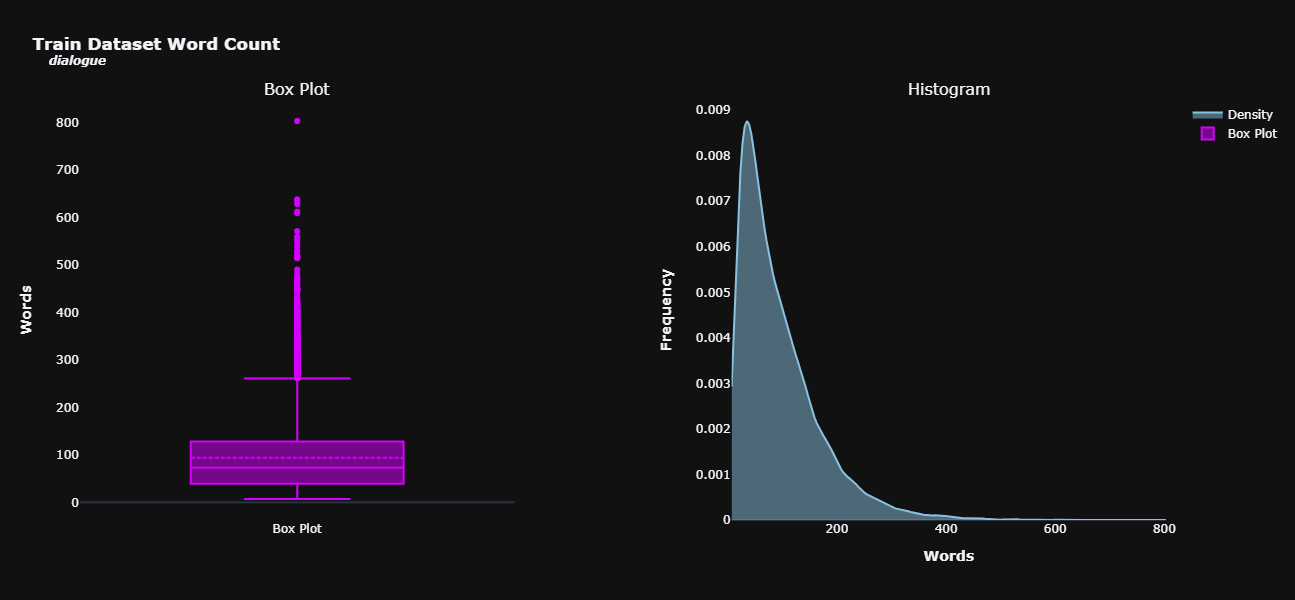

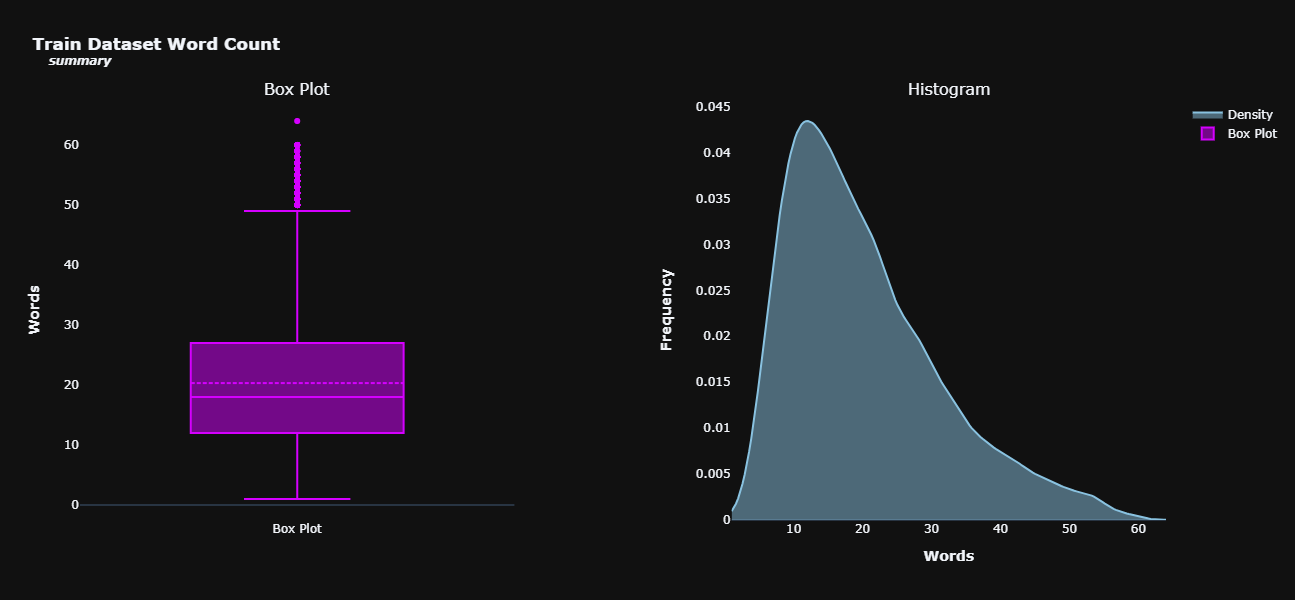

In [24]:
df_text_lenght = pd.DataFrame() # Creating an empty dataframe
for feat in categorical_features: # Iterating through features --> Dialogue & Summary
    df_text_lenght[feat] = train[feat].apply(lambda x: len(str(x).split())) #  Counting words for each feature

# Plotting histogram-boxplot
histogram_boxplot(df_text_lenght,'#89c2e0', '#d500ff', 600, 1000, True, 'Train Dataset')

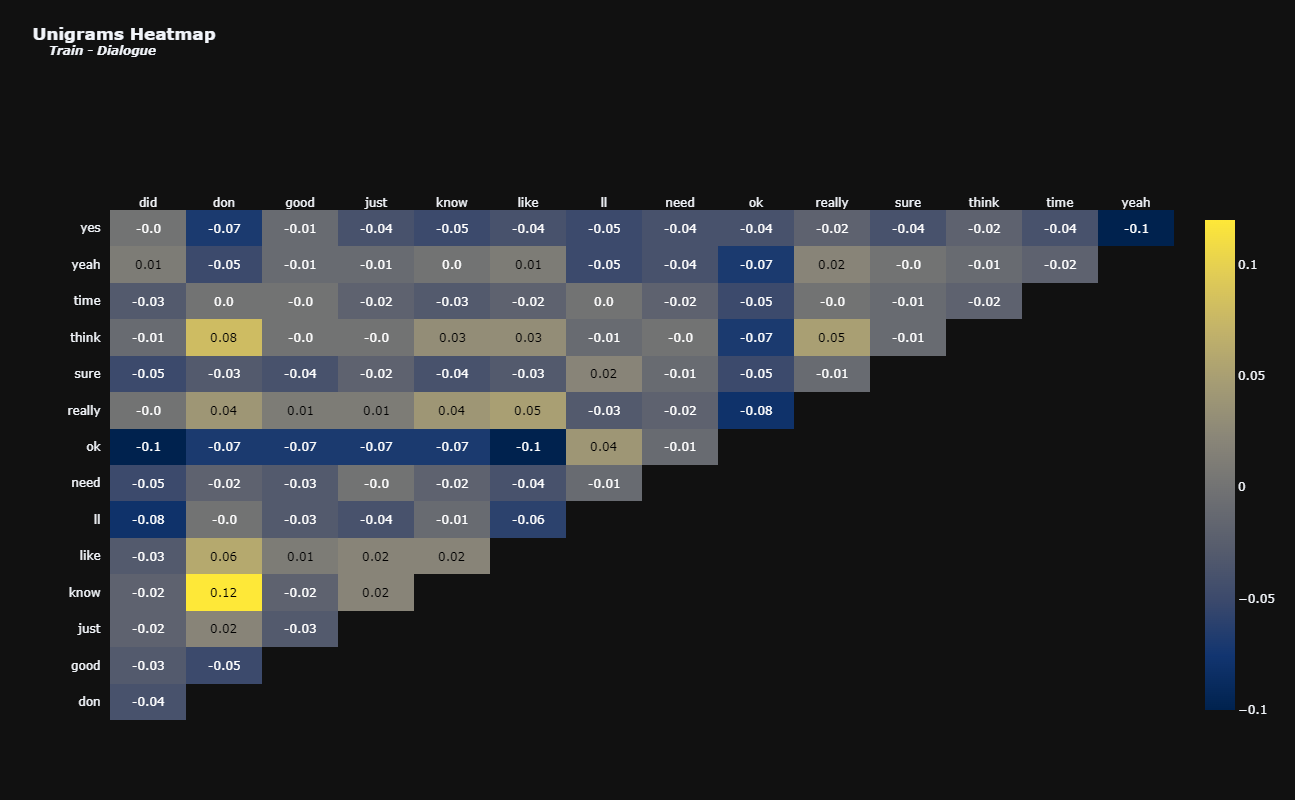

In [25]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(train['dialogue'])
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Train - Dialogue', 800, 800, 12)

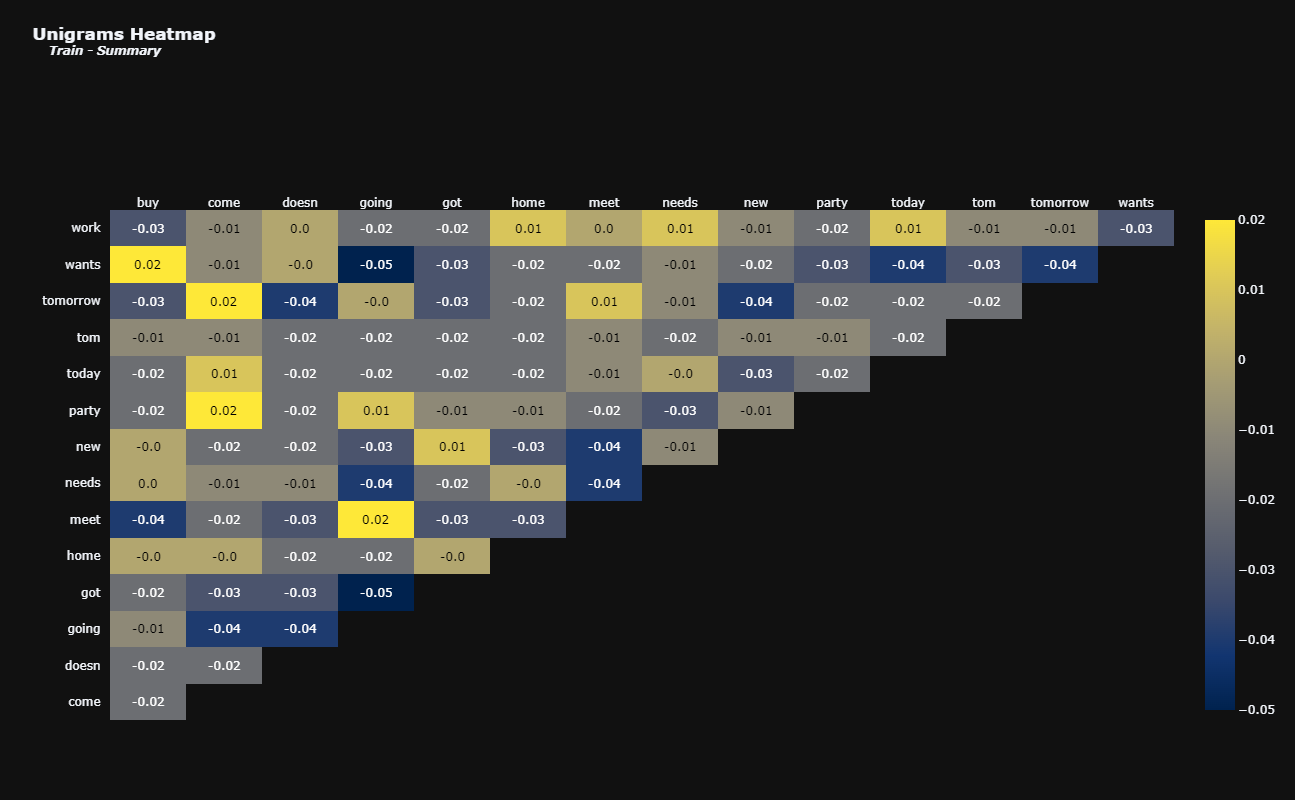

In [26]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(train['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Train - Summary', 800, 800, 12)

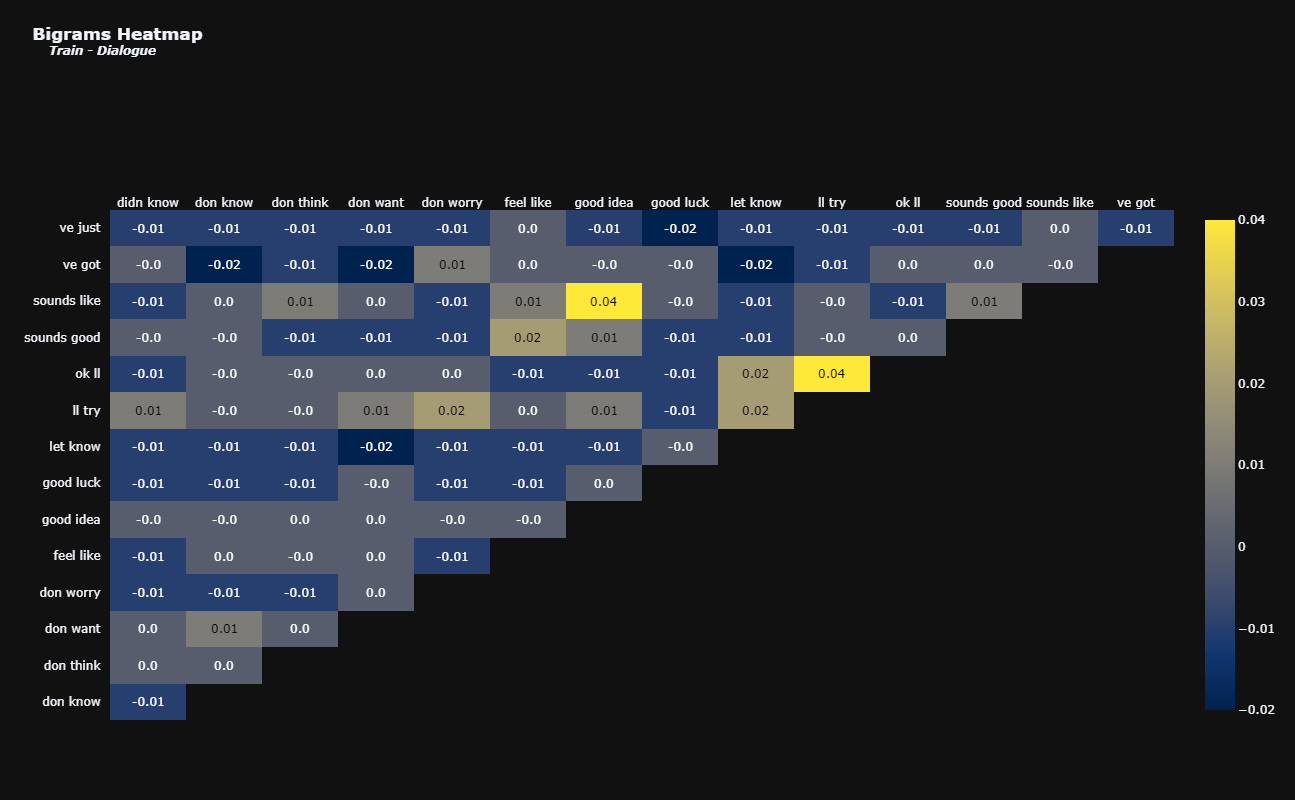

In [27]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(train['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Train - Dialogue', 800, 800, 12)

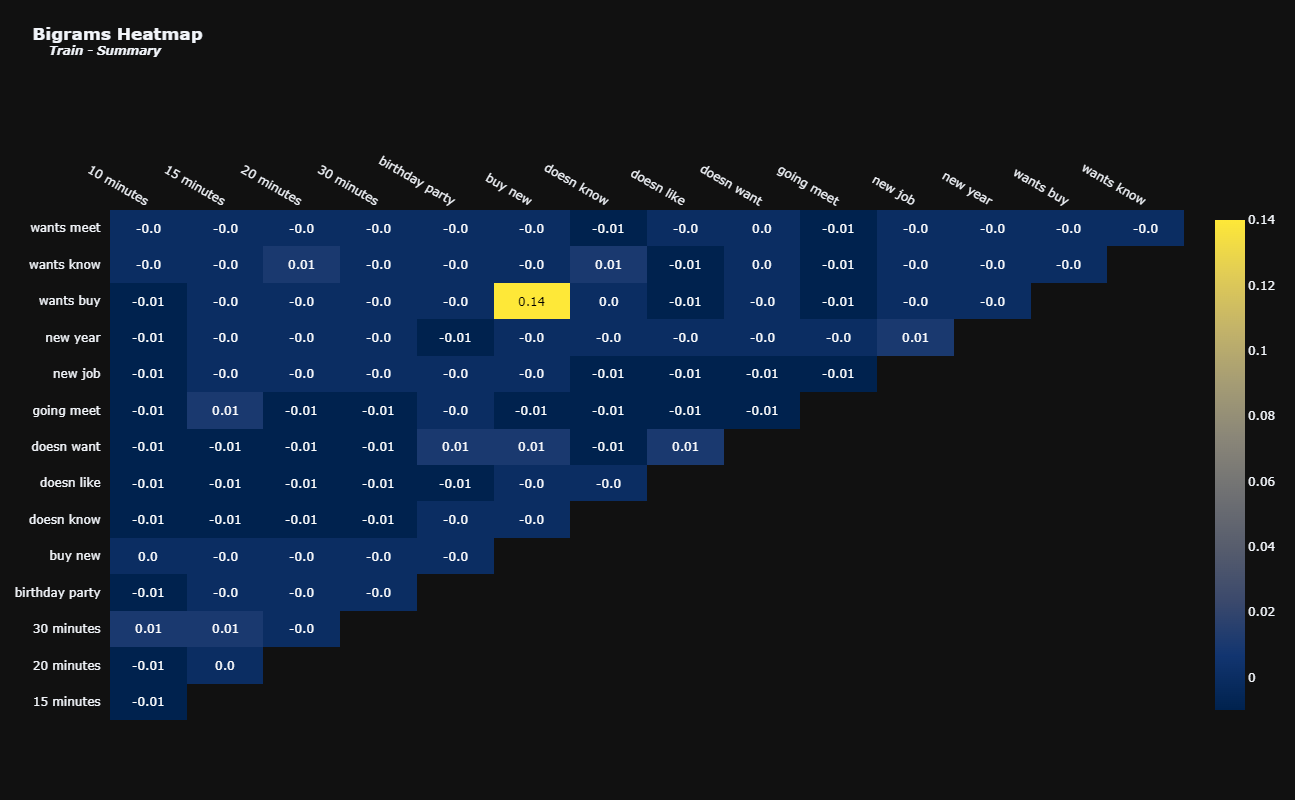

In [28]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(train['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Train - Summary', 800, 800, 12)

In [29]:
# Filtering dataset to see those containing the term '15 minutes' in the summary
filtered_train = train[train['summary'].str.contains('15 minutes', case=False, na=False)]
filtered_train.head()

,id,dialogue,summary
136,13827893,"Kate: I'm here <file_other>\r\nKate: there was no place in Red Lion\r\nSteven: hey! but it's quite far away\r\nKate: c'mon it's just 10 min by bike!\r\nSteven: yes, but I'm not by bike\r\nKate: car?\r\nSteven: nope\r\nSteven: by foot :P :P \r\nSteven: anyway google maps says 15 min and I'm there:D\r\nKate: ok, w8in ^^",Kate will meet with Steven in 15 minutes.
428,13811484-1,"Jenny: Let's go out to eat.\r\nLucy: That sounds like fun.\r\nJenny: Where do you wanna go?\r\nLucy: Let me think a minute.\r\nJenny: I feel like Chinese.\r\nLucy: That sounds yummy.\r\nJenny: I know a good Chinese restaurant.\r\nLucy: How far away is it?\r\nJenny: It's only 10 minutes from my place.\r\nLucy: Do we have to book a table?\r\nJenny: Oh, no. We can walk right in.\r\nLucy: Cool. Will be in 15 minute. I'm really hungry!",Jenny and Lucy are going to a Chinese restaurant to eat. They do not need to book a table. Lucy will be at Jenny's in 15 minutes.
570,13818296,Danielle: hey where RU?\r\nJuan: I told u I'd be late!\r\nDanielle: but it's been almost 45 mins!\r\nDanielle: <file_gif>\r\nJuan: I'll be there in 15 minutes\r\nJuan: <file_gif>,Juan is almost 45 minutes late. He'll be there in 15 minutes.
1213,13682296-1,"John: I know you will be outraged but I like to provoke you :P\r\nTyre: What is it?\r\nJohn: I talked to our neighbour today and I am really starting to think that religious people are just stupid.\r\nTyre: Gosh. You know it's a stupid claim.\r\nJohn: I know that there are some clever, religious individuals. But statistically religious people are stupid.\r\nTyre: It's not true. There are stupid religious people and clever ones, just like atheists.\r\nJohn: But most of academics are not religious.\r\nTyre: How do you know it?\r\nJohn: Experience but also some data I've seen.\r\nTyre: It's just not true.\r\nJohn: They are mostly people believing in things that have nothing to do with logic or reason: miracles, ghosts, witchcraft, just as our neighbour.\r\nTyre: I think it's only one part of them. There are theologians, people who actually know a lot about philosophy, logic etc.\r\nJohn: Yes, there are also people doing ""scientifically"" tarot, horoscopes and astrology.\r\nTyre: You ca...",John and Tyre's neighbour stopped John in the staircase and talked about some miracles for 15 minutes. John thinks that religious people are stupid. Tyre disagrees with this generalization.
1812,13820691,"Madge: are you alive? xD\r\nDorothy: i'm still drunk\r\nMadge: xDDDDDDDD jeeez\r\nFelicia: I don't know...how much did i drink?\r\nMadge: like 10 rounds\r\nFelicia: SHIT \r\nFelicia: you gotta be kidding me ahahaha xDDDDDDDDDDDDDDDDDD\r\nDorothy: of course she is\r\nDorothy: it was at least 15\r\nFelicia: ;________________;\r\nFelicia: was nice to meet you girls...shame on me as always\r\nDorothy: oh stop talking\r\nDorothy: just live the moment B-)\r\nFelicia: how am i supossed to live the moment if i don't remember the half o the night XD\r\nDorothy: well it happens :p \r\nMadge: we gotta repeat it, i had a lot of fun :D\r\nDorothy: i'm in. in 15min?\r\nFelicia: you're crazy ;-;",Dorothy is still intoxicated after at least 15 rounds of drink yesterday and can't remember much of what happened. She would like to meet her friends for a drink again in 15 minutes.


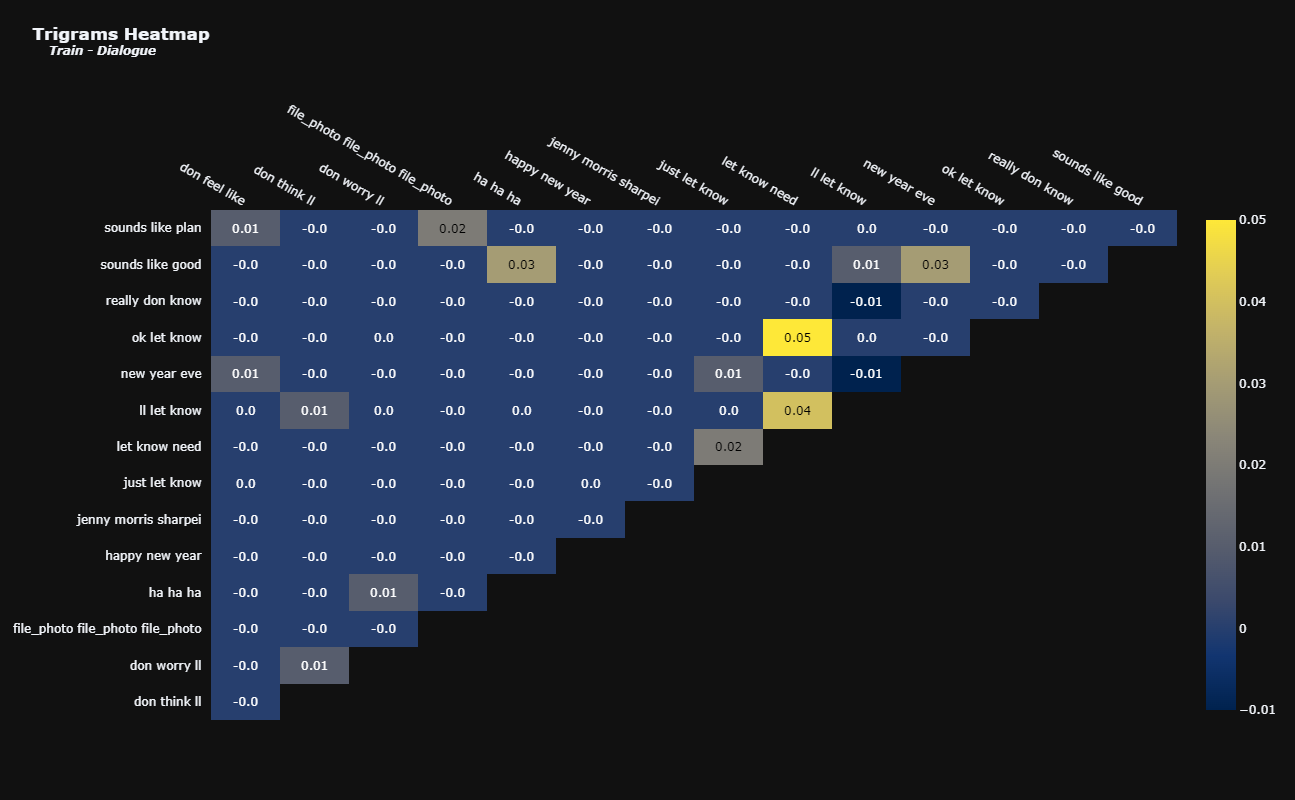

In [30]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(train['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Train - Dialogue', 800, 800, 12)

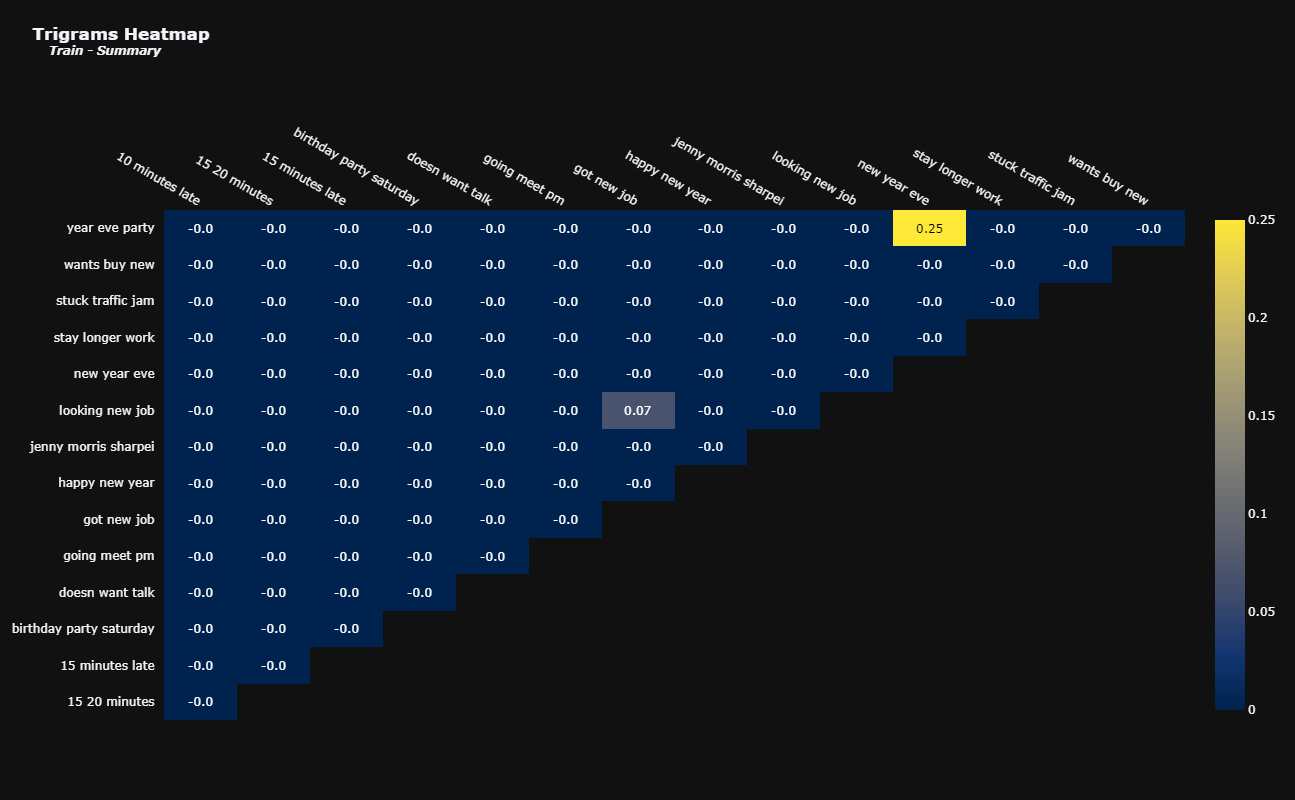

In [31]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(train['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Train - Summary', 800, 800, 12)

In [32]:
# Extracting info on the test dataset
describe_df(test)


DataFrame shape: (819, 3)

819 samples

3 attributes

Missing Data: 
id          0
dialogue    0
summary     0
dtype: int64

Duplicates: 0

Data Types: 
id          object
dialogue    object
summary     object
dtype: object

Categorical Features: 
id, dialogue, summary

Continuous Features: 
None

Binary Features: 
None

DataFrame Head: 



,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :),Eric and Rob are going to watch a stand-up on youtube.
2,13680171,"Lenny: Babe, can you help me with something?\r\nBob: Sure, what's up?\r\nLenny: Which one should I pick?\r\nBob: Send me photos\r\nLenny: <file_photo>\r\nLenny: <file_photo>\r\nLenny: <file_photo>\r\nBob: I like the first ones best\r\nLenny: But I already have purple trousers. Does it make sense to have two pairs?\r\nBob: I have four black pairs :D :D\r\nLenny: yeah, but shouldn't I pick a different color?\r\nBob: what matters is what you'll give you the most outfit options\r\nLenny: So I guess I'll buy the first or the third pair then\r\nBob: Pick the best quality then\r\nLenny: ur right, thx\r\nBob: no prob :)",Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.
3,13729438,"Will: hey babe, what do you want for dinner tonight?\r\nEmma: gah, don't even worry about it tonight\r\nWill: what do you mean? everything ok?\r\nEmma: not really, but it's ok, don't worry about cooking though, I'm not hungry\r\nWill: Well what time will you be home?\r\nEmma: soon, hopefully\r\nWill: you sure? Maybe you want me to pick you up?\r\nEmma: no no it's alright. I'll be home soon, i'll tell you when I get home. \r\nWill: Alright, love you. \r\nEmma: love you too.",Emma will be home soon and she will let Will know.
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, just back! Btw are you free for diner the 19th?\r\nOllie: nope!\r\nJane: and the 18th?\r\nOllie: nope, we have this party and you must be there, remember?\r\nJane: oh right! i lost my calendar.. thanks for reminding me\r\nOllie: we have lunch this week?\r\nJane: with pleasure!\r\nOllie: friday?\r\nJane: ok\r\nJane: what do you mean "" we don't have any more whisky!"" lol..\r\nOllie: what!!!\r\nJane: you just call me and the all thing i heard was that sentence about whisky... what's wrong with you?\r\nOllie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol\r\nJane: dont' worry, we'll check on friday.\r\nOllie: don't forget to bring some sun with you\r\nJane: I can't wait to be in Morocco..\r\nOllie: enjoy and see you friday\r\nJane: sorry Ollie, i'm very busy, i won't have time for lunch tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!\r\nOllie: ok fo...",Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm.



DataFrame Tail: 



,id,dialogue,summary
814,13611902-1,"Alex: Were you able to attend Friday night's basketball game?\r\nBenjamin: I was unable to make it.\r\nAlex: You should have been there. It was intense.\r\nBenjamin: Is that right. Who ended up winning?\r\nAlex: Our team was victorious.\r\nBenjamin: I wish I was free that night. I'm kind of mad that I didn't go.\r\nAlex: It was a great game. Everything alright tough?\r\nBenjamin: Yeah man thanks for asking, it's just that my mom is sick and I am taking care of her.\r\nAlex: Oh sorry to hear that. Hope she makes a fast recovery 💪\r\nBenjamin: She will, she just has a nasty flu but she will be alright :D\r\nAlex: Glad to hear that!\r\nBenjamin: What was the score at the end of the game?\r\nAlex: Our team won 101-98.\r\nBenjamin: Sounds like it was a close game then.\r\nAlex: That's the reason it was such a great game.\r\nBenjamin: I'll go to the next one for sure.\r\nAlex: It's next weekend so you better put on your calendar ahaha\r\nBenjamin: ahaha I will I will. Talk to you later!\...",Benjamin didn't come to see a basketball game on Friday's night. The team supported by Alex won 101-98. Benjamin's mom has a flu and he's looking after her. Benjamin declares to attend the next basketball match.
815,13820989,Jamilla: remember that the audition starts at 7.30 P.M.\r\nKiki: which station?\r\nJamilla: Antena 3\r\nYoyo: roger that,The audition starts at 7.30 P.M. in Antena 3.
816,13717193,"Marta: <file_gif>\r\nMarta: Sorry girls, I clicked something by accident :D\r\nAgnieszka: No problem :p\r\nWeronika: Hahaha\r\nAgnieszka: Good thing you didn't send something from your gallery ;)","Marta sent a file accidentally,"
817,13829115,"Cora: Have you heard how much fuss British media made about meet and greet with James Charles in Birmingham?\r\nEllie: no...! what happened?\r\nCora: Well, there was a meet and greet with James Charles in one of the malls in Birmingham and about 8000 fans showed up for it.\r\nCora: It cause a gridlock around the mall and - of course - British media had to make some (quite negative) comments on it.\r\nEllie: they came for sister James?! >:(\r\nEllie: i sister snapped!! :p :D\r\nCora: Haha :D\r\nCora: You shouldn't watch so much youtube, you're getting weirder and weirder. :d\r\nEllie: sister shut up :P so, what did they say?\r\nCora: ;) :* ""Daily Mail"" was surprised that a meet and greet with a ""virtually unknown"" youtuber gathered 8000 people. :p\r\nCora: A host from LBC tried to find an answer to an unanswerable question: ""Who is James Charles?"". Eventually James called him and introduced himself. On air. :D\r\nEllie: there's something called google lol\r\nCora: Right? :p\r\nCora:...",There was a meet-and-greet with James Charles in Birmingham which gathered 8000 people.
818,13818810,"Rachel: <file_other>\r\nRachel: Top 50 Best Films of 2018\r\nRachel: :)\r\nJanice: Omg, I've watched almost all 50... xDD\r\nSpencer: Hahah, Deadpool 2 also??\r\nJanice: Yep\r\nSpencer: Really??\r\nJanice: My bf forced me to watch it xD\r\nRachel: Hahah\r\nJanice: It wasn't that bad\r\nJanice: I thought it'd be worse\r\nRachel: And Avengers? :D\r\nJanice: 2 times\r\nRachel: Omg\r\nJanice: xP\r\nRachel: You are the best gf in the world\r\nRachel: Your bf should appreciate that ;-)\r\nJanice: He does\r\nJanice: x)","Rachel sends a list of Top 50 films of 2018. Janice watched almost half of them, Deadpool 2 and Avengers included."


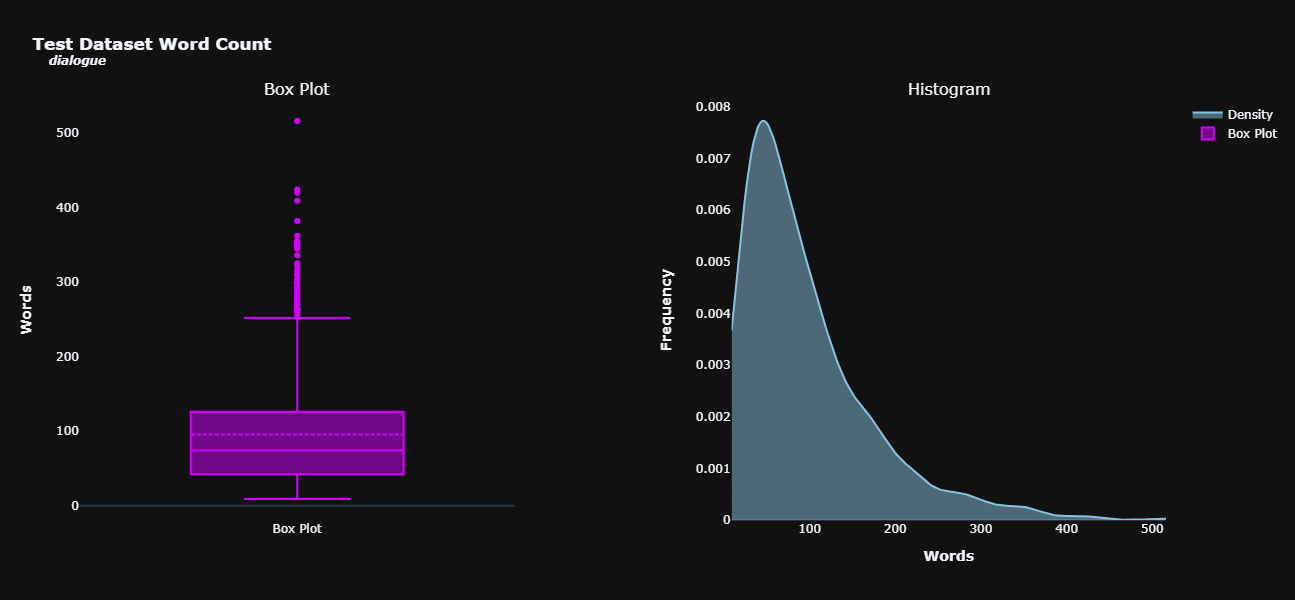

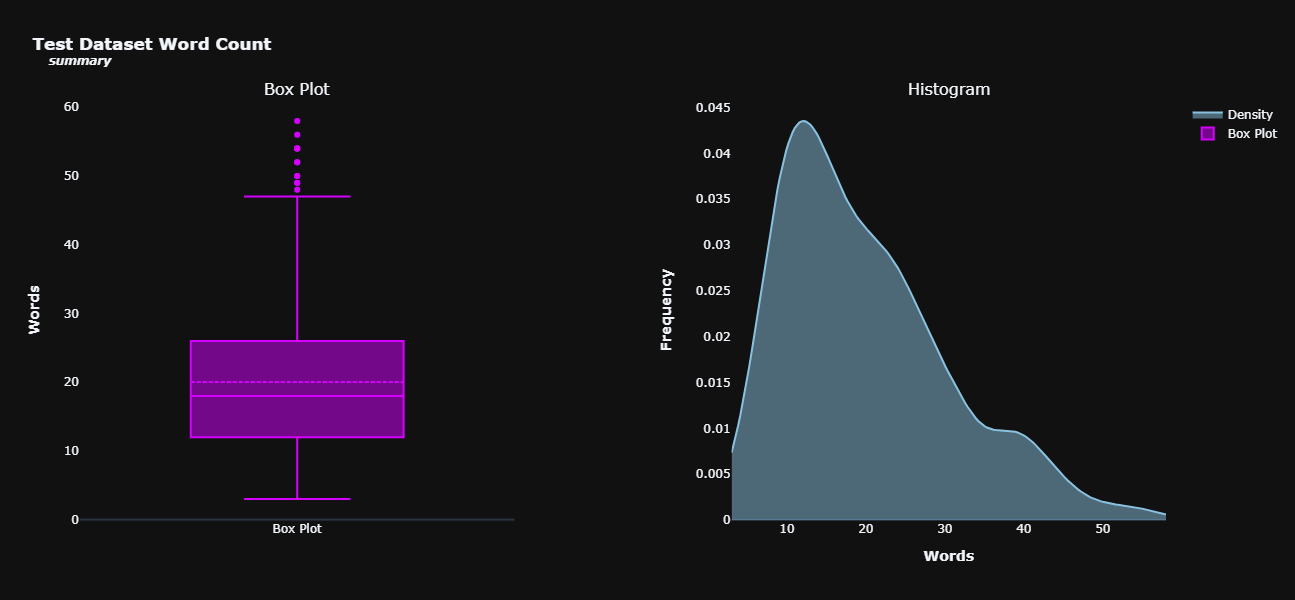

In [35]:
df_text_lenght = pd.DataFrame()
for feat in categorical_features:
    df_text_lenght[feat] = test[feat].apply(lambda x: len(str(x).split()))

histogram_boxplot(df_text_lenght,'#89c2e0', '#d500ff', 600, 1000, True, 'Test Dataset')

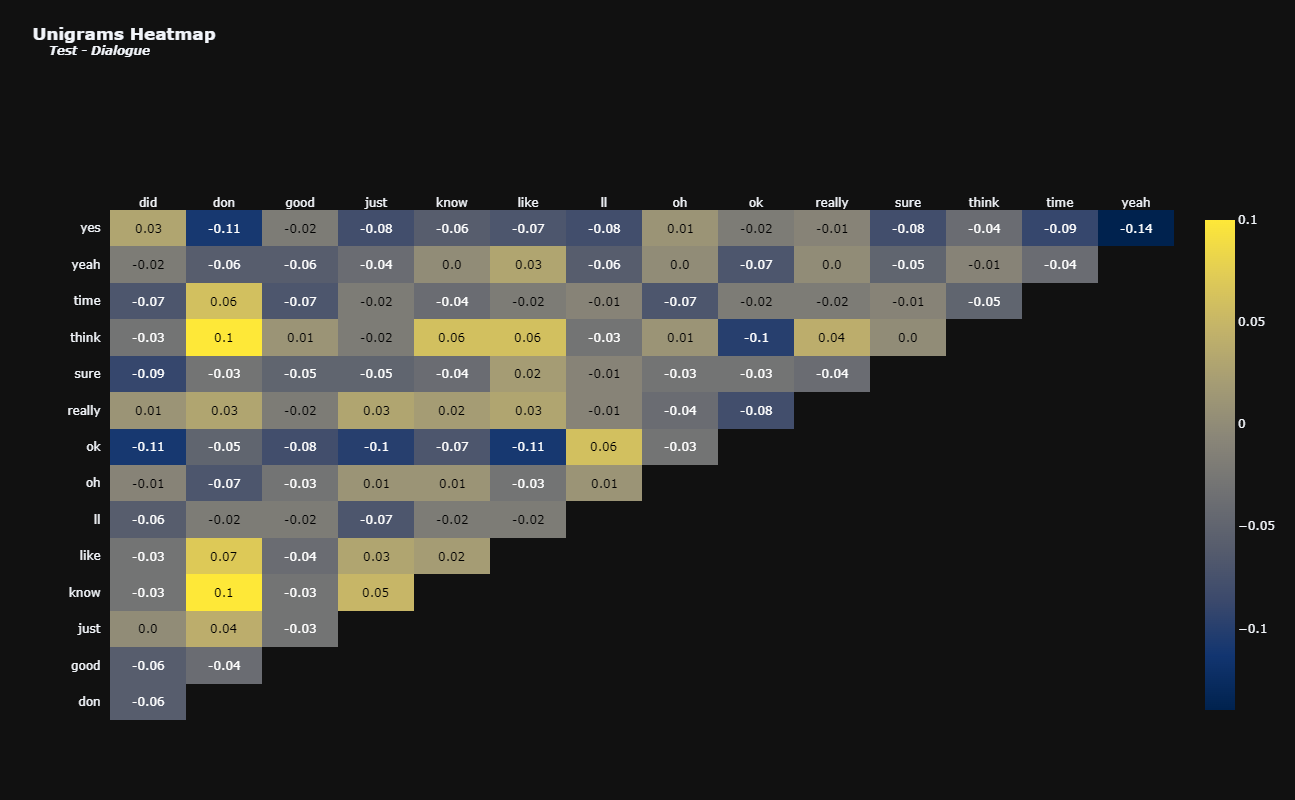

In [36]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(test['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Test - Dialogue', 800, 800, 12)

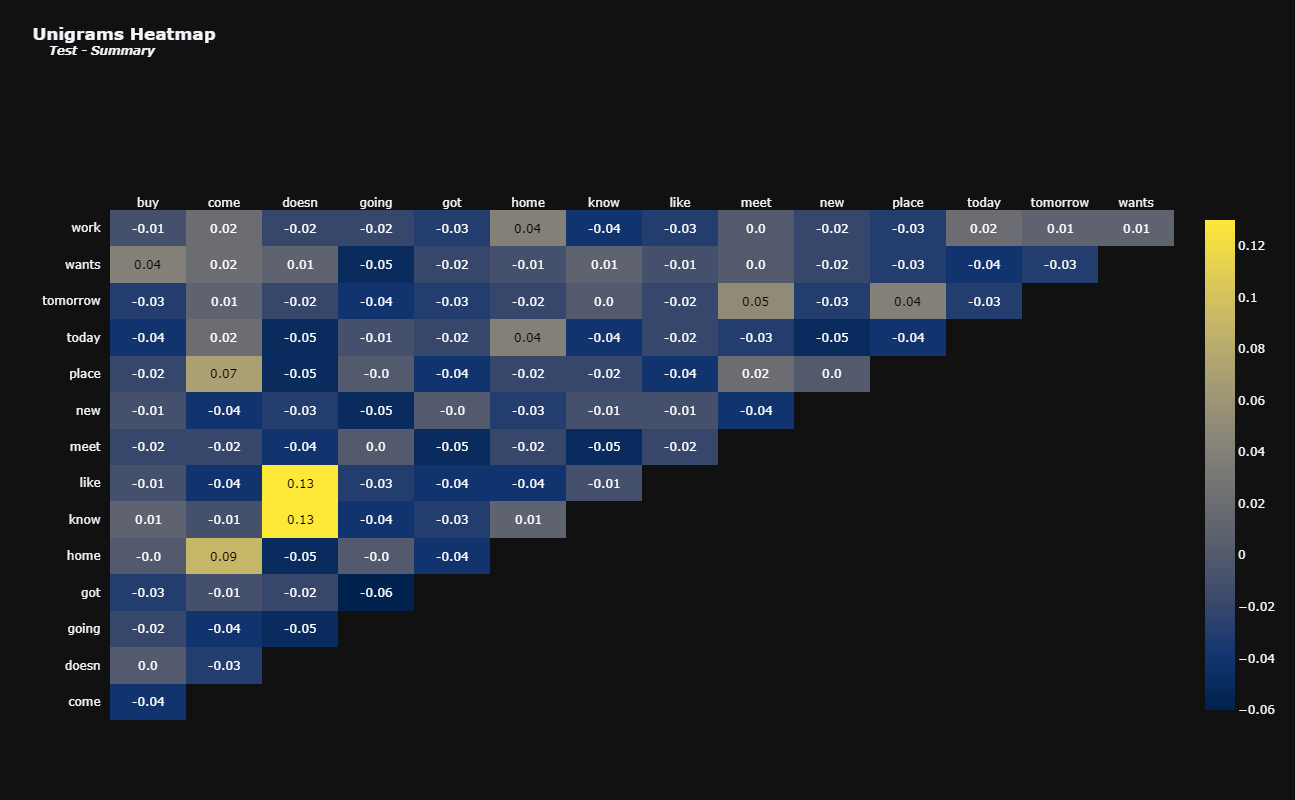

In [37]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(test['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Test - Summary', 800, 800, 12)

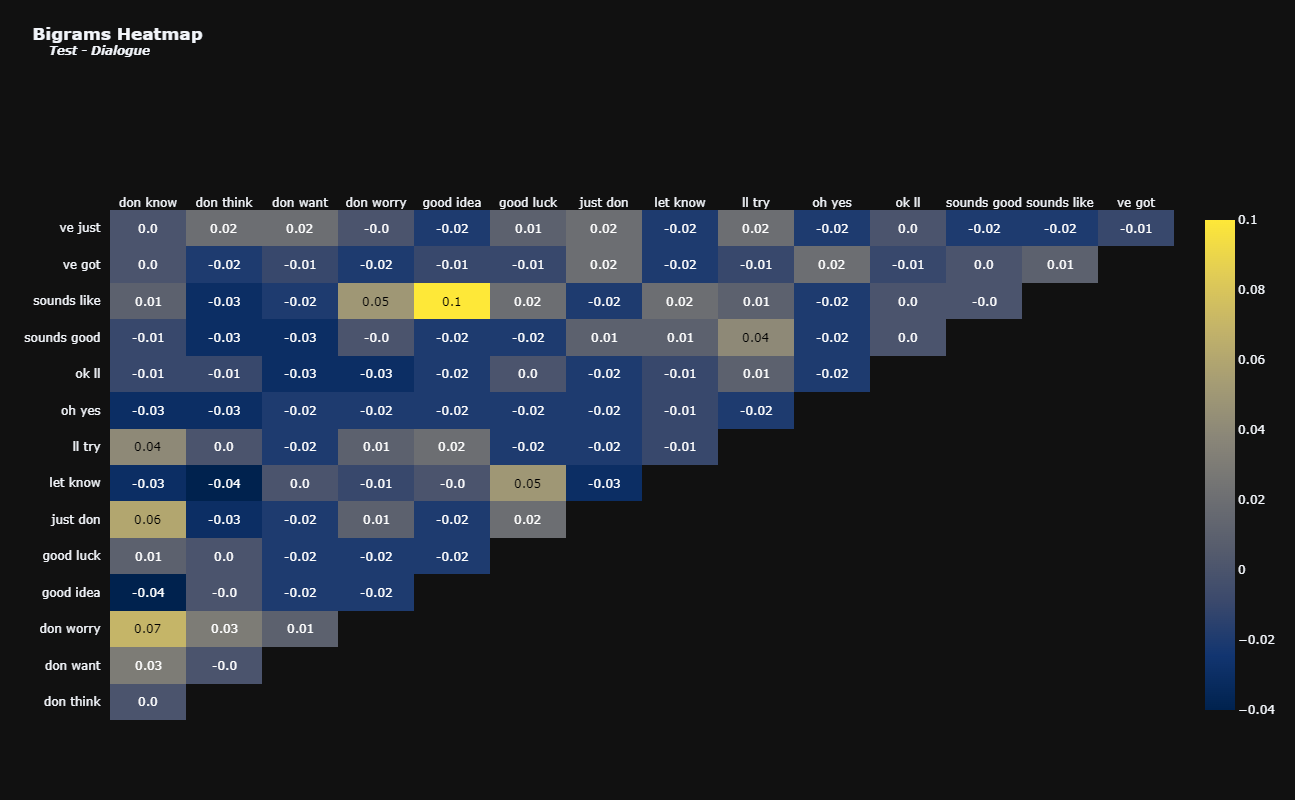

In [38]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(test['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Test - Dialogue', 800, 800, 12)

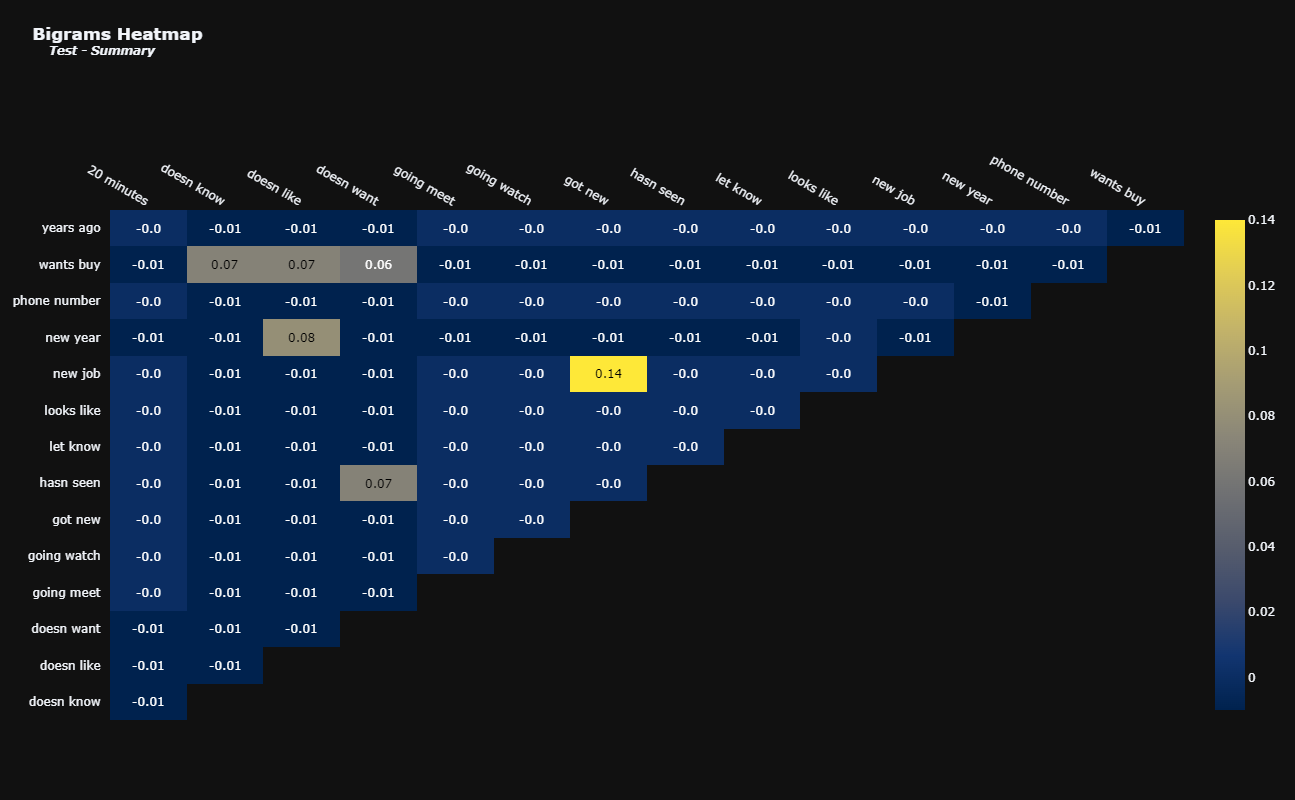

In [39]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(test['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Test - Summary', 800, 800, 12)

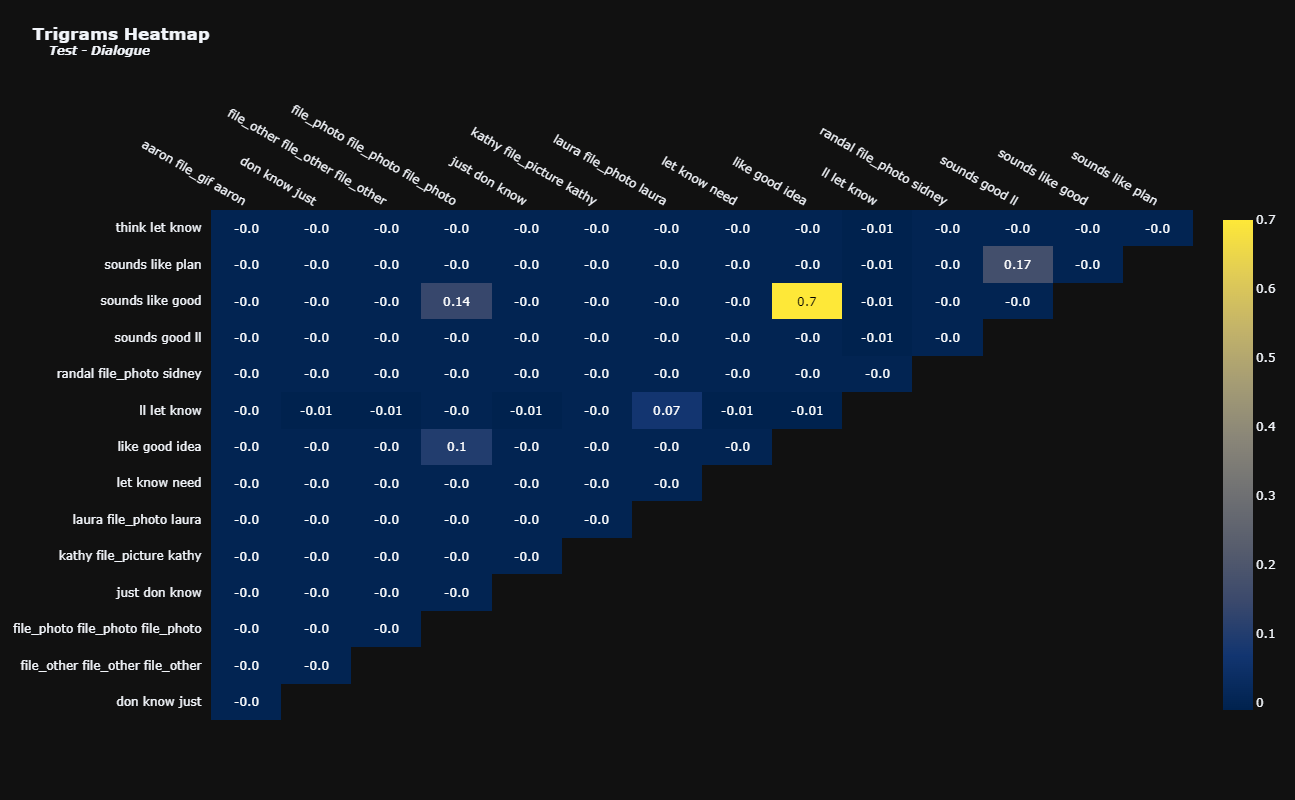

In [40]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(test['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Test - Dialogue', 800, 800, 12)

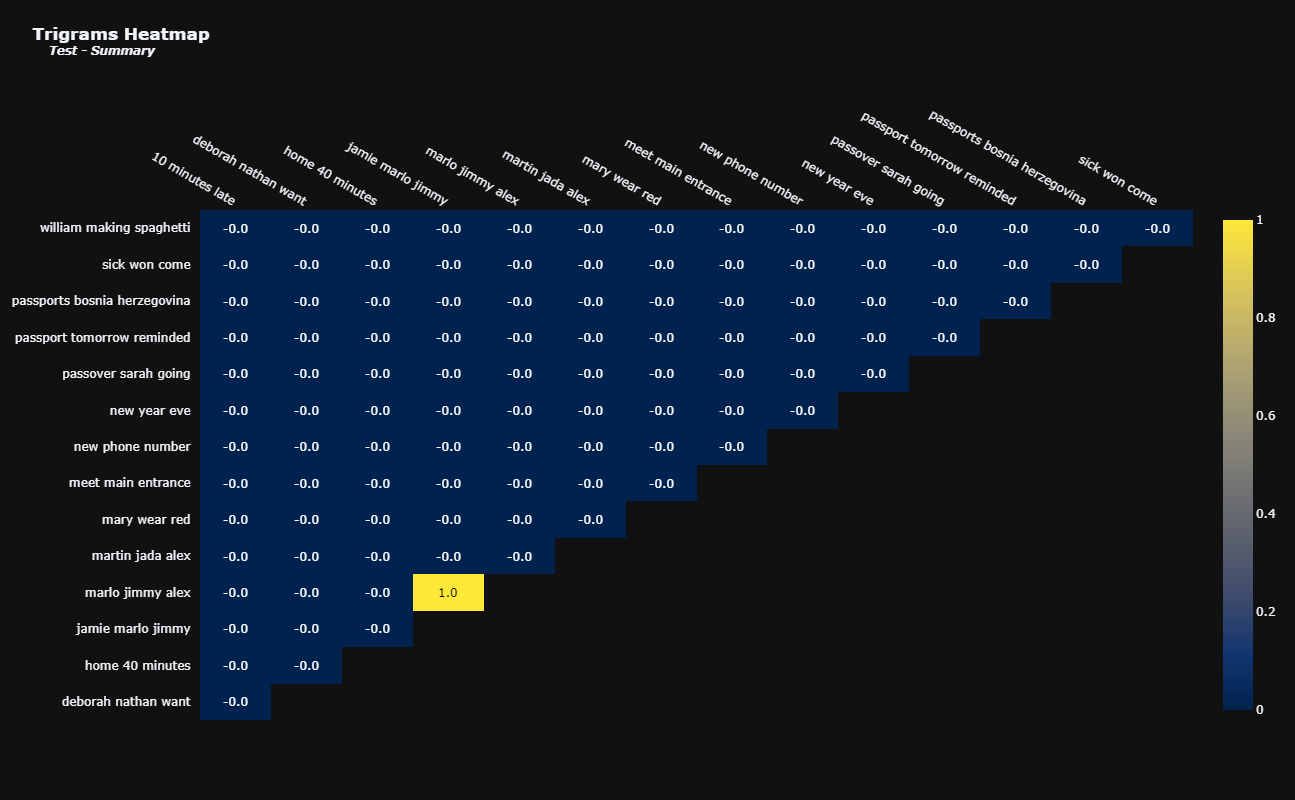

In [41]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(test['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Test - Summary', 800, 800, 12)

In [42]:
# Extracting info on the val dataset
describe_df(val)


DataFrame shape: (818, 3)

818 samples

3 attributes

Missing Data: 
id          0
dialogue    0
summary     0
dtype: int64

Duplicates: 0

Data Types: 
id          object
dialogue    object
summary     object
dtype: object

Categorical Features: 
id, dialogue, summary

Continuous Features: 
None

Binary Features: 
None

DataFrame Head: 



,id,dialogue,summary
0,13817023,"A: Hi Tom, are you busy tomorrow’s afternoon?\r\nB: I’m pretty sure I am. What’s up?\r\nA: Can you go with me to the animal shelter?.\r\nB: What do you want to do?\r\nA: I want to get a puppy for my son.\r\nB: That will make him so happy.\r\nA: Yeah, we’ve discussed it many times. I think he’s ready now.\r\nB: That’s good. Raising a dog is a tough issue. Like having a baby ;-) \r\nA: I'll get him one of those little dogs.\r\nB: One that won't grow up too big;-)\r\nA: And eat too much;-))\r\nB: Do you know which one he would like?\r\nA: Oh, yes, I took him there last Monday. He showed me one that he really liked.\r\nB: I bet you had to drag him away.\r\nA: He wanted to take it home right away ;-).\r\nB: I wonder what he'll name it.\r\nA: He said he’d name it after his dead hamster – Lemmy - he's a great Motorhead fan :-)))",A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy.
1,13716628,"Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!\r\nRob: I used to get one every year as a child! Loved them! \r\nEmma: Yeah, i remember! they were filled with chocolates!\r\nLauren: they are different these days! much more sophisticated! Haha!\r\nRob: yeah, they can be fabric/ wooden, shop bought/ homemade, filled with various stuff\r\nEmma: what do you fit inside?\r\nLauren: small toys, Christmas decorations, creative stuff, hair bands & clips, stickers, pencils & rubbers, small puzzles, sweets\r\nEmma: WOW! That’s brill! X\r\nLauren: i add one more very special thing as well- little notes asking my children to do something nice for someone else\r\nRob: i like that! My sister adds notes asking her kids questions about christmas such as What did the 3 wise men bring? etc\r\nLauren: i reckon it prepares them for Christmas \r\nEmma: and makes it more about traditions and being kind to other people\r\nLauren: my children get very excited eve...","Emma and Rob love the advent calendar. Lauren fits inside calendar various items, for instance, small toys and Christmas decorations. Her children are excited whenever they get the calendar."
2,13829420,Jackie: Madison is pregnant\r\nJackie: but she doesn't wanna talk about it\r\nIggy: why\r\nJackie: I don't know why because she doesn't wanna talk about it\r\nIggy: ok\r\nJackie: I wanted to prepare you for it because people get super excited and ask lots of questions\r\nJackie: and she looked way more anxious than excited\r\nIggy: she's probably worrying about it\r\nIggy: she's taking every commitment really seriously\r\nJackie: it could be money problems or relationship problems\r\nIggy: or maybe she wants an abortion\r\nJackie: it could be all of the above\r\nIggy: but you know what?\r\nIggy: once my friend was pregnant and I couldn't bring myself to be happy about it\r\nJackie: why?\r\nIggy: I felt they were immature and I couldn't picture this couple as parents\r\nJackie: I felt similar way on Patricia's wedding\r\nIggy: Patricia Stevens?\r\nJackie: yes\r\nIggy: so we're talking about the same person\r\nJackie: what a coincidence\r\nJackie: so she's pregnant?\r\nIggy: she thou...,Madison is pregnant but she doesn't want to talk about it. Patricia Stevens got married and she thought she was pregnant.
3,13819648,"Marla: <file_photo>\r\nMarla: look what I found under my bed\r\nKiki: lol\r\nTamara: is that someone's underwear?\r\nMarla: it certainly isn't mine, my ass is big but it isn't huge\r\nKiki: it looks like male underwear\r\nTamara: not necessarily, maybe some butch had fun in your room while you were gone\r\nMarla: ok but how can you leave your underwear after hooking up? wtf is wrong with people\r\nKiki: she or he could be too wasted to notice\r\nTamara: or maybe someone put their pants there to piss you off\r\nMarla: that makes no sense\r\nMarla: it's so fucking childish\r\nKiki: if it's childish then it must have been your sister


DataFrame Tail: 



,id,dialogue,summary
813,13829423,"Carla: I've got it...\r\nDiego: what?\r\nCarla: my date for graduation. Hope you're coming\r\nDiego: if you tell me when...\r\nCarla: oups sorry. June 4th\r\nDiego: we've got time.\r\nCarla: of course, but you have to book your plane\r\nDiego: i still don't know, and it's quite expensive\r\nCarla: that's why you have to book it right now. Please tell me you'll come\r\nDiego: i'd love to for sure\r\nCarla: come, come, please\r\nDiego: ok, i'll have a look and tell you.\r\nCarla: you could stay home for the week, my roommate won't be there.\r\nDiego: didn't you tell me your parents would come?\r\nCarla: yes they will, but they've got friends they could stay with.\r\nDiego: what was the company you flew with when you came last month?\r\nCarla: aeromexico was the cheapest at that time, but check with delta\r\nDiego: i think there is some flight comparison websites and also some apps.\r\nCarla: i only know the canadian one\r\nDiego: don't worry i'll find out \r\nCarla: ok ! i've to l...",Carla's date for graduation is on June 4th. Diego will try to come then.
814,13727710,"Gita: Hello, this is Beti's Mum Gita, I wanted to ask if you were going on the school trip?\r\nBev: Hi Gita, yes, Milo wants me to come, he's a bit nervous going away from home or school still.\r\nGita: Yes, Beti is the same, they are still only 4 or 5 after all.\r\nBev: I know, still so young! It will help the teachers and TAs anyway, they have a lot to cope with!\r\nGita: I know, I could never do their job! I work part time as a music teacher, going round schools.\r\nBev: Oh really? I am in Marks, part time too, love it there! \r\nGita: Yes, it really helps to do some sort of work doesn't it! I could never manage full time, though.\r\nBev: Oh, I know, Gita. My sister's in management and she doesn't see her kids from 6.30am to 6.30pm every day! She is a high flier, but she does miss them. She does do lots with them on the weekend, though.\r\nGita: Yes, but children need time to just be at home and play or just be with family, not galavanting around all the time!\r\nBev: I agree 10...",Bev is going on the school trip with her son. Gita is going on the school trip with her daughter. Bev's sister rarely sees her children during the week because of her job. Gita has a few pets at home. The mothers with their children have to be at school at 7.45 to not miss the bus.
815,13829261,"Julia: Greg just texted me\r\nRobert: ugh, delete him already\r\nJulia: He's saying he's sorry\r\nRobert: damn girl, delete the bastard\r\nJulia: it's not that simple, you know it\r\nRobert: No Julia, it is pretty simple\r\nRobert: go and delete him\r\nJulia: But he apologised, ok? He's never done it before\r\nRobert: srsly?\r\nRobert: do I need to remind you he cheated on you?\r\nRobert: Julia I'm not going through this again with you\r\nJulia: People change, I do believe it, maybe he changed. He apologised\r\nRobert: and that's it? That' ok? how's different from two other times?\r\nJulia: i told you - he apologised! he's sorry, he wants to meet\r\nRobert: don't, honey, really. We've been through this\r\nJulia: I know, but it's not easy. I think I love him\r\nRobert: i know you do, but you need to be strong. do you want to come over?\r\nJulia: no, thank you love, but i have to get up early tomorrow\r\nRobert: ok, you should go to sleep then\r\nJulia: what about Greg?\r\nRobert: do...",Greg cheated on Julia. He apologises to her. Robert tells Julia not to meet Greg.
816,13680226,"Marry: I broke my nail ;(\r\nTina: oh, no!\r\nMarry: u know I have that party tomorrow!!!\r\nTina: I know, let me think...\r\nTina: I got it!. My sister friend is a cosmetitian, maybe she 'll help\r\nMarry: anyone will be good, I'm desperate!\r\nTina: I'll call her and let u know, ok?\r\nMarry: ok, I'll wait, but hurry!",Marry broke her nail and has a party tomorrow. Tina will call a cosmetician that she knows and let Marry know if she can help.
817,13862383,"Paige: I asked them t

An error occurred: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


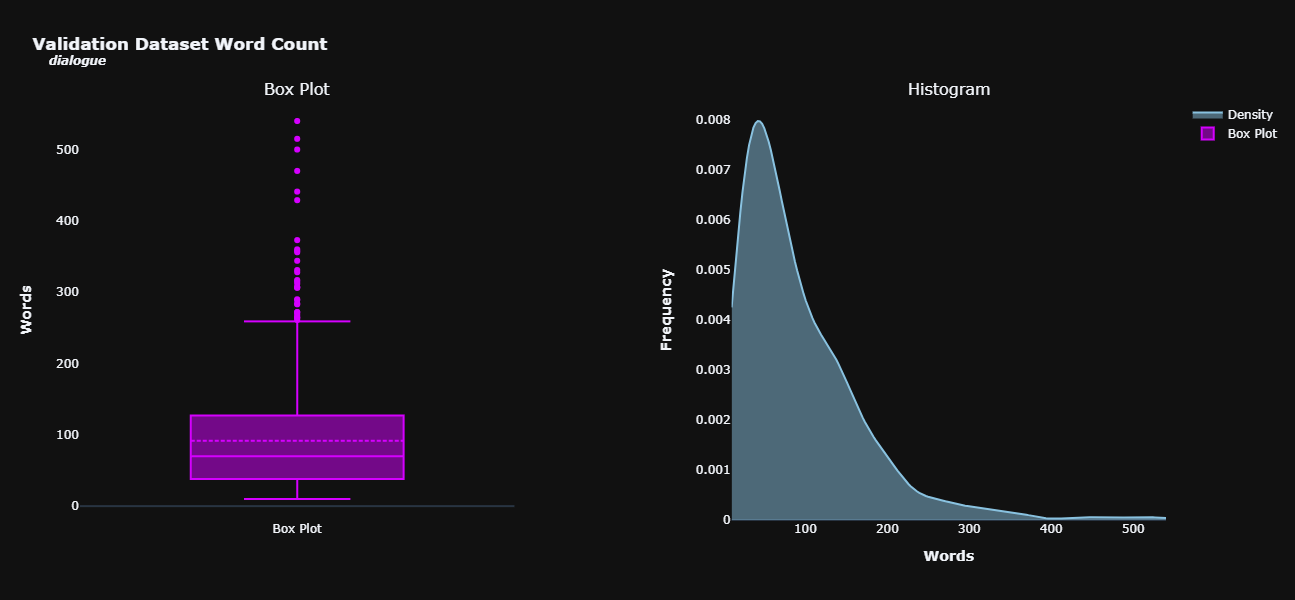

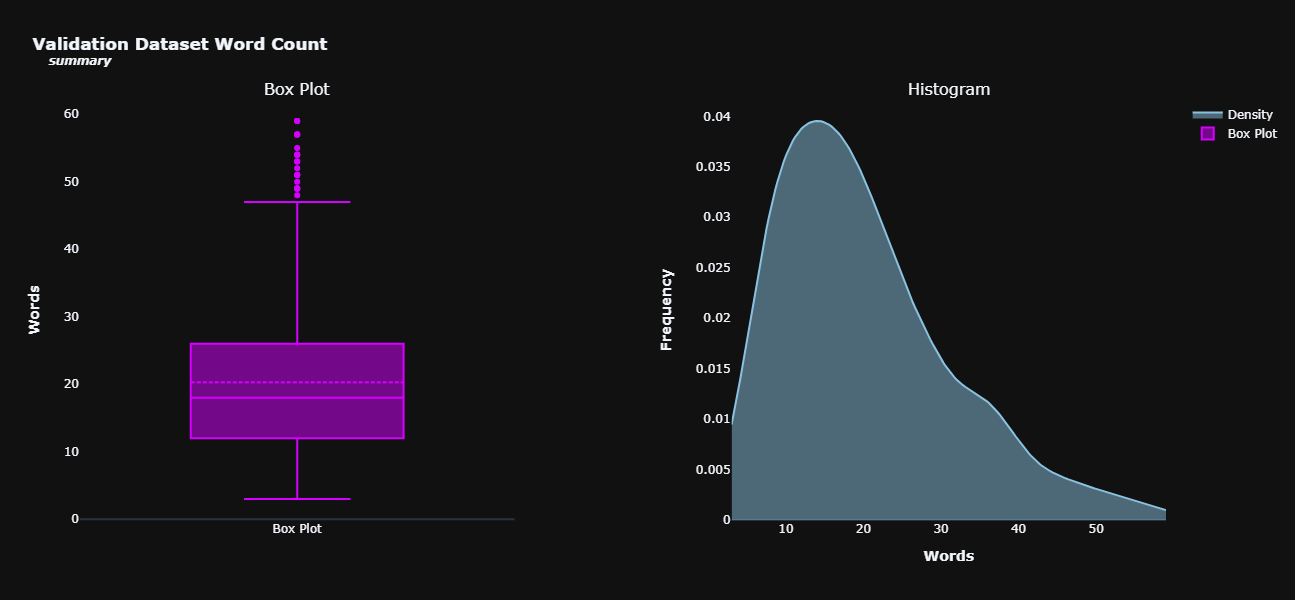

In [43]:
df_text_lenght = pd.DataFrame()
for feat in categorical_features:
    df_text_lenght[feat] = val[feat].apply(lambda x: len(str(x).split()))

histogram_boxplot(df_text_lenght,'#89c2e0', '#d500ff', 600, 1000, True, 'Validation Dataset')

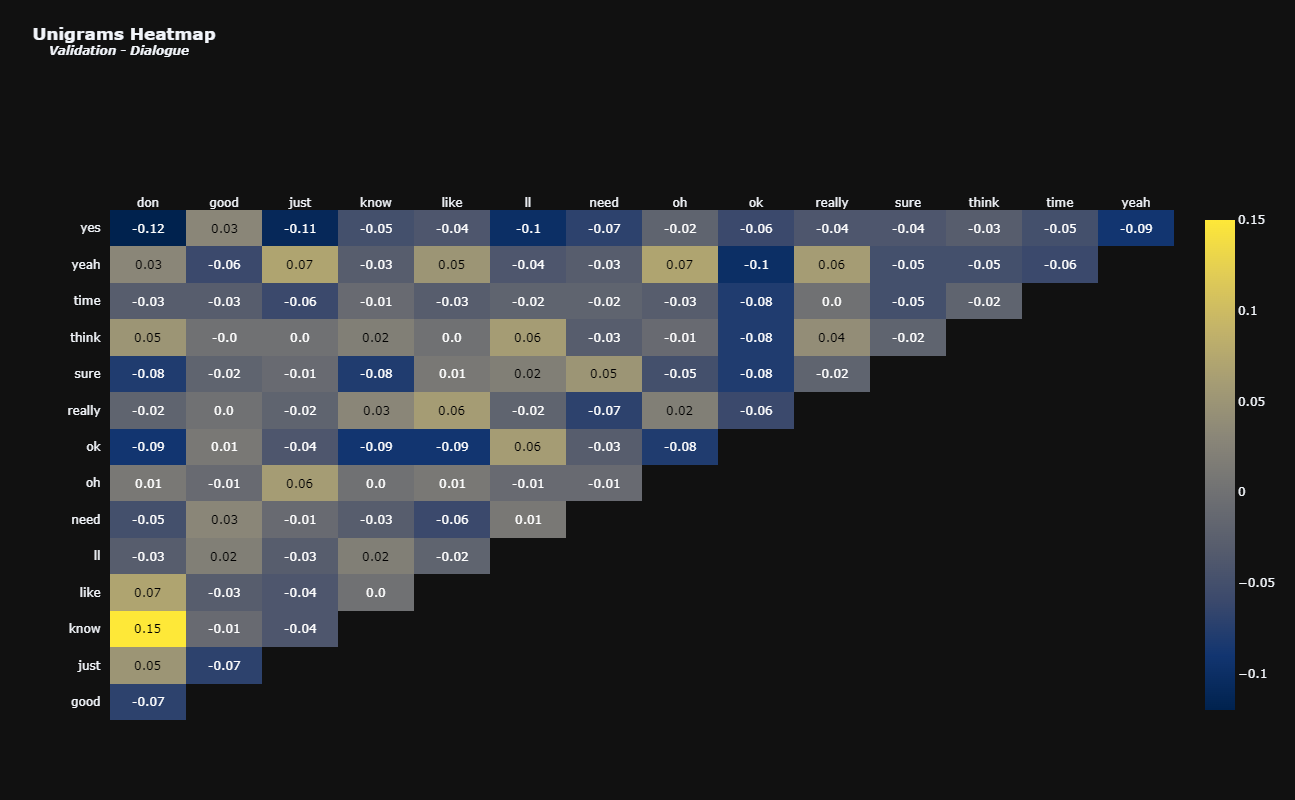

In [44]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(val['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Validation - Dialogue', 800, 800, 12)

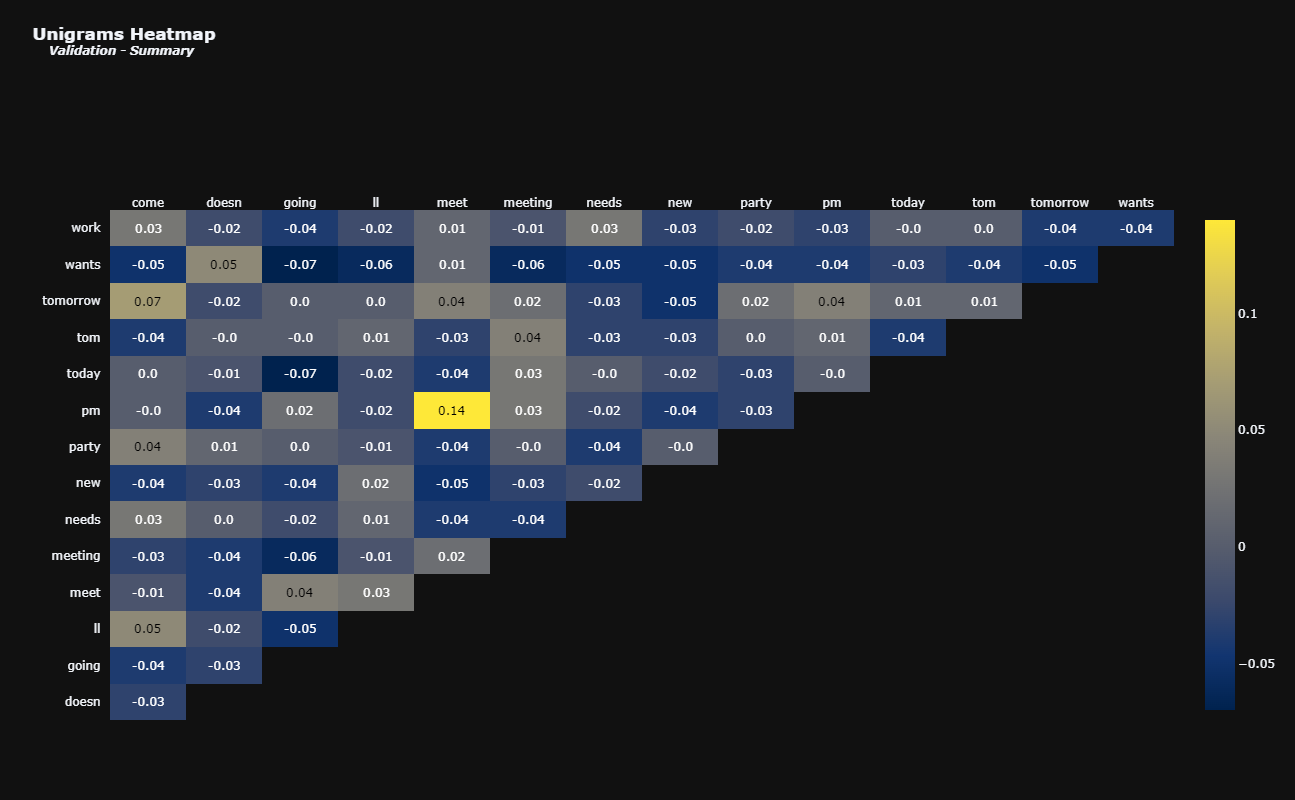

In [45]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(val['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Validation - Summary', 800, 800, 12)

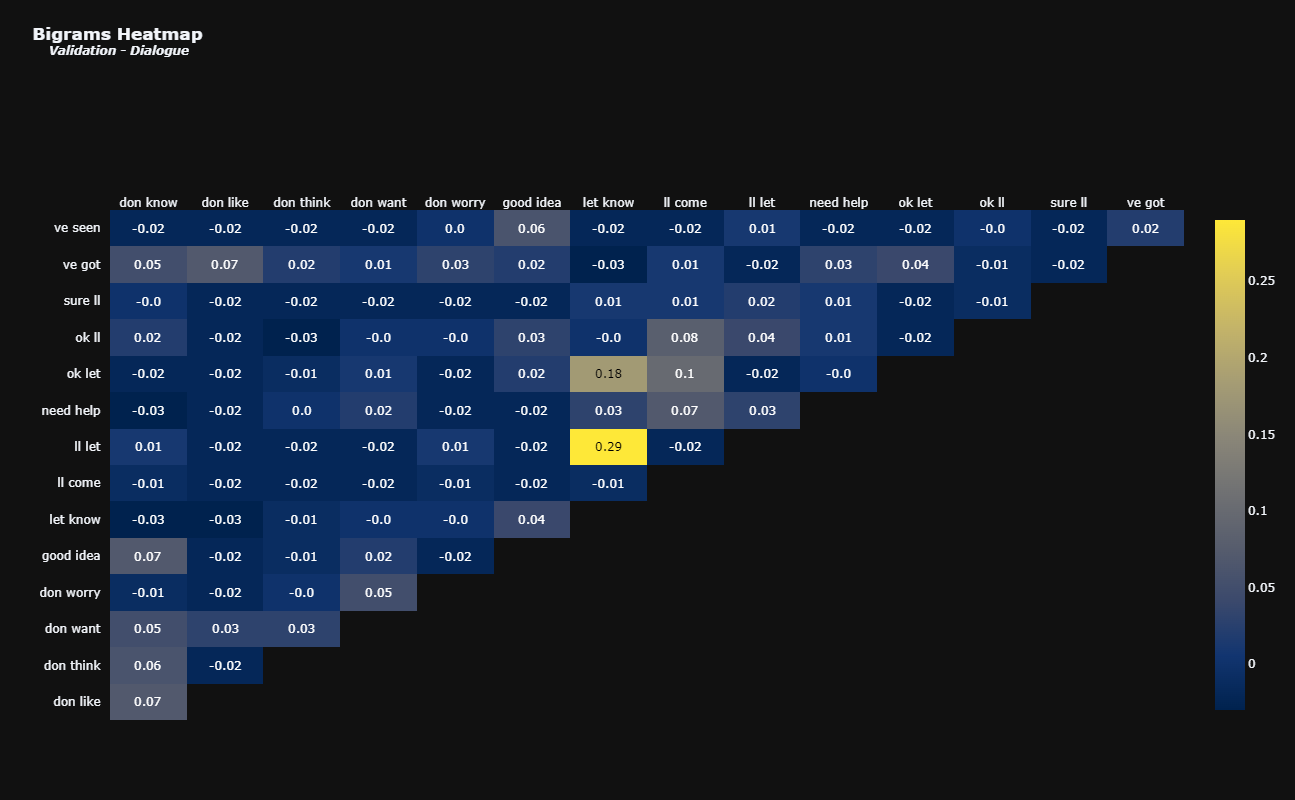

In [46]:

vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(val['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Validation - Dialogue', 800, 800, 12)

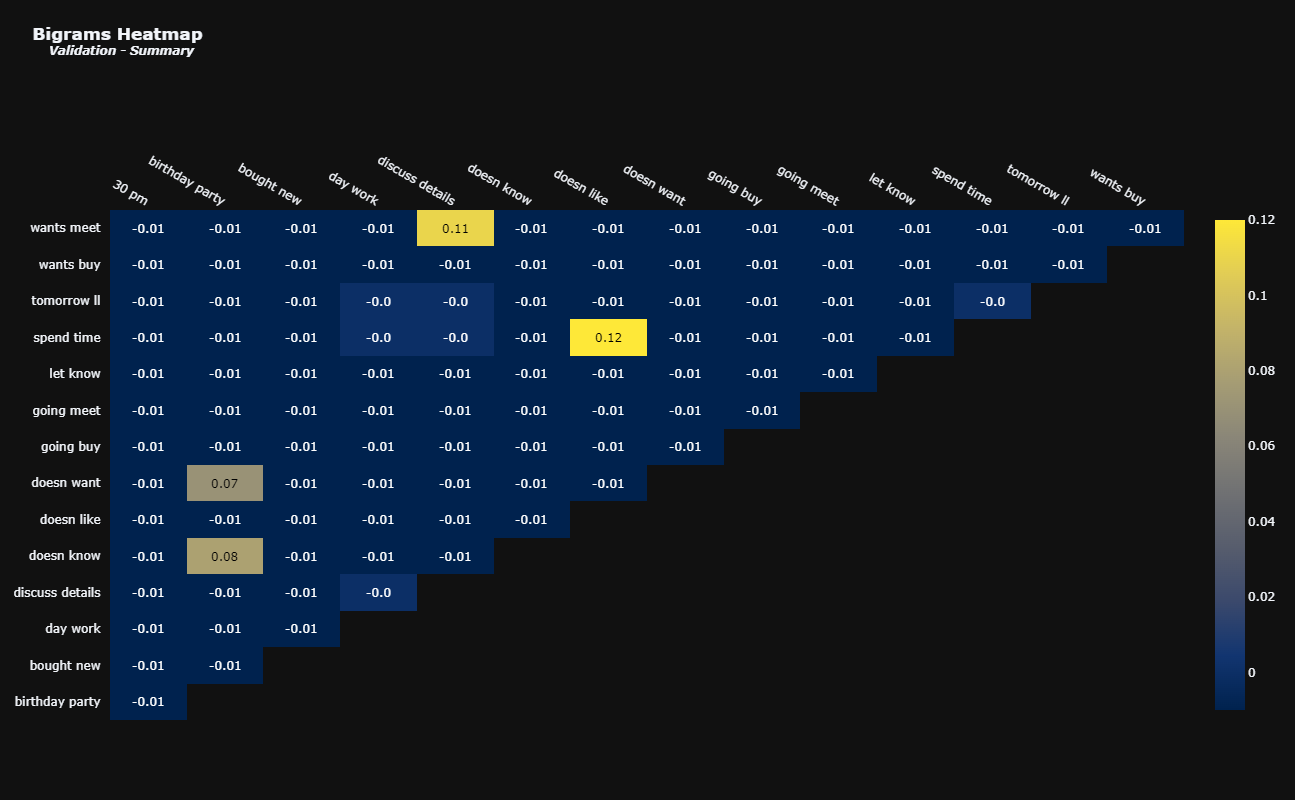

In [47]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(val['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Validation - Summary', 800, 800, 12)

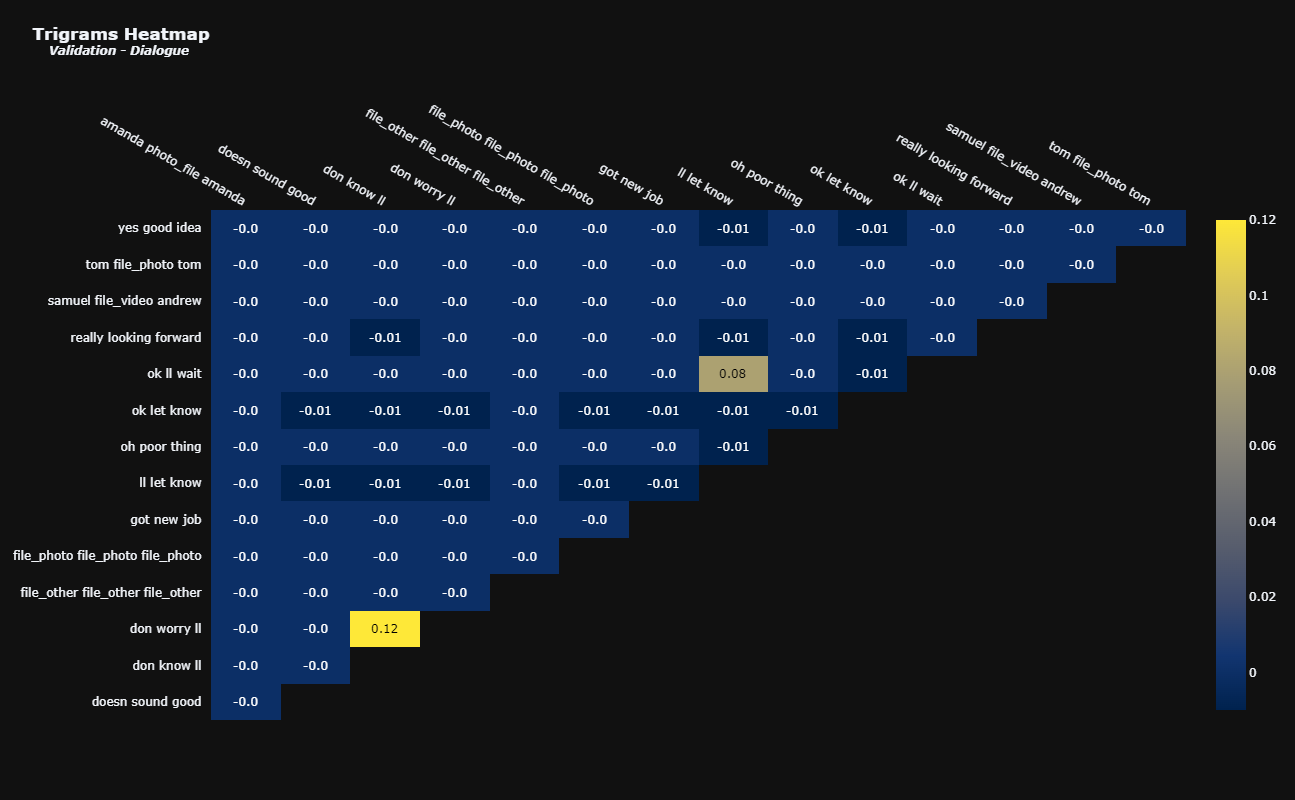

In [49]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(val['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Validation - Dialogue', 800, 800, 12)

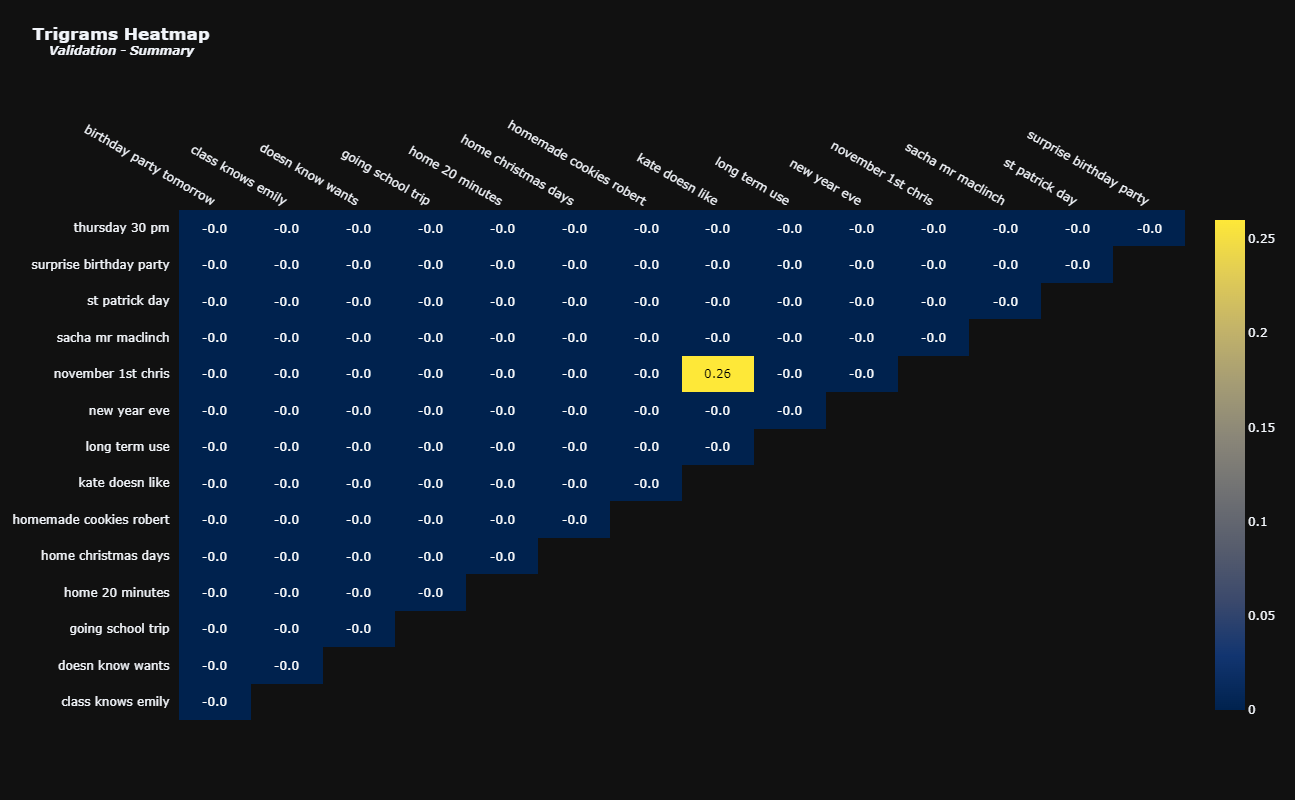

In [50]:

vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(val['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Validation - Summary', 800, 800, 12)

In [51]:
print(train['dialogue'].iloc[14727])

Theresa: <file_photo>
Theresa: <file_photo>
Theresa: Hey Louise, how are u?
Theresa: This is my workplace, they always give us so much food here 😊
Theresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂
Louise: Hey!! 🙂 
Louise: Wow, that's awesome, seems great 😎 Haha
Louise: I'm good! Are you coming to visit Stockholm this summer? 🙂
Theresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter
Louise: Nice! Do you already know which classes you will attend?
Theresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)
Louise: Very good! Is it at the Uni in Prague?
Theresa: No, it will be in my home town :)
Louise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!
Theresa: You must send me some pictures, so I can see where you live :) 
Louise: I will, and of my cat and dog too 🤗
Theresa: Yeeeesss pl

In [52]:
print(test['dialogue'].iloc[0])

Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye


In [53]:
def clean_tags(text):
    clean = re.compile('<.*?>') # Compiling tags
    clean = re.sub(clean, '', text) # Replacing tags text by an empty string

    # Removing empty dialogues
    clean = '\n'.join([line for line in clean.split('\n') if not re.match('.*:\s*$', line)])

    return clean

In [54]:
test1 = clean_tags(train['dialogue'].iloc[14727]) # Applying function to example text
test2 = clean_tags(test['dialogue'].iloc[0]) # Applying function to example text

# Printing results
print(test1)
print('\n' *3)
print(test2)

Theresa: Hey Louise, how are u?
Theresa: This is my workplace, they always give us so much food here 😊
Theresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂
Louise: Hey!! 🙂 
Louise: Wow, that's awesome, seems great 😎 Haha
Louise: I'm good! Are you coming to visit Stockholm this summer? 🙂
Theresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter
Louise: Nice! Do you already know which classes you will attend?
Theresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)
Louise: Very good! Is it at the Uni in Prague?
Theresa: No, it will be in my home town :)
Louise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!
Theresa: You must send me some pictures, so I can see where you live :) 
Louise: I will, and of my cat and dog too 🤗
Theresa: Yeeeesss pls :)))
Louise: 👌👌
Theresa: 🐱💕




Hannah: He

In [55]:
# Defining function to clean every text in the dataset.
def clean_df(df, cols):
    for col in cols:
        df[col] = df[col].fillna('').apply(clean_tags)
    return df

In [56]:
# Cleaning texts in all datasets
train = clean_df(train,['dialogue', 'summary'])
test = clean_df(test,['dialogue', 'summary'])
val = clean_df(val,['dialogue', 'summary'])

In [57]:
train.tail(3) # Visualizing results

,id,dialogue,summary
14729,13819050,"John: Every day some bad news. Japan will hunt whales again\r\nErica: Yes, I've read this. It's very upsetting\r\nJohn: Cruel Japanese\r\nFaith: I think this is a racist remark. Because Island and Norways has never joined this international whaling agreement\r\nErica: really? I haven't known, everybody is so outraged by Japan\r\nFaith: sure, European hypocrisy \r\nJohn: not entirely. Scandinavians don't use the nets that Japanese use, so Norway and Island kill much less specimens that Japan will\r\nFaith: oh, it's much more complex than one may expect\r\nJohn: True, but the truth is, that all of them should stop\r\nJohn: and this decision is a step back\r\nFaith: yes, this is worrying\r\nErica: And it seems that the most important whaling countries are out of the agreement right now\r\nFaith: yes, seems so\r\nJohn: Just like USA leaving the Paris Agreement",Japan is going to hunt whales again. Island and Norway never stopped hunting them. The Scandinavians kill fewer whales than the Japanese.
14730,13828395,"Jennifer: Dear Celia! How are you doing?\r\nJennifer: The afternoon with the Collins was very pleasant, nice folks, but we missed you.\r\nJennifer: But I appreciate your consideration for Peter.\r\nCelia: My dear Jenny! It turns out that my decision not to come, though I wanted so much to see you again and Peter and the Collins, was right. Yesterday it all developed into a full bore cold. Sh.....\r\nCelia: All symptoms like in a text book.\r\nCelia: Luckily it's contagious only on the first 2, 3 days, so when we meet next week it should be alright.\r\nCelia: Thanks for asking! Somehow for all of us Peter comes first now.\r\nJennifer: That's too bad. Poor you...\r\nJennifer: I'll be driving to FR, do you want me to bring you sth? It's on my way.\r\nCelia: Thank you dear! I was at the pharmacy yesterday and had done my shopping the day before.\r\nCelia: You'd better still stay away from me in case I'm still contagious\r\nJennifer: Right. So I'll only leave a basket on your terrace. A...","Celia couldn't make it to the afternoon with the Collins and Jennifer as she is ill. She's working, but doesn't want to meet with Jennifer as it might be contagious. Jennifer will leave a basket with cookies on Celia's terrace."
14731,13729017,"Georgia: are you ready for hotel hunting? We need to book something finally for Lisbon\r\nJuliette: sure we can go on, show me what you found\r\nJuliette: nah... it looks like an old lady's room lol\r\nJuliette: that's better... but the bed doesn't look very comfortable\r\nGeorgia: i kind of like it and it's really close to the city center\r\nJuliette: show me the others please\r\nJuliette: nah... this one sucks too, look at those horrible curtains \r\nGeorgia: aff Julie you are such a princess\r\nJuliette: i just want to be comfortable\r\nGeorgia: come on, stop whining you know we are on a budget\r\nJuliette: well hopefully we can find something that's decent right?\r\nGeorgia: i did show you decent but you want a Marriott or something :/\r\nJuliette: ok ok don't get angry\r\nGeorgia: we need to decide today, the longer we wait the higher the prices get \r\nJuliette: ok how about we get the second one then?\r\nGeorgia: ok give me a second\r\nJuliette: sure\r\nGeorgia: affff someon...","Georgia and Juliette are looking for a hotel in Lisbon. Juliette dislikes Georgia's choices. Juliette and Georgia decide on the second option presented by Georgia, but it has already been booked. Finally Georgia books the third hotel."


In [58]:

# Transforming dataframes into datasets
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)
val_ds = Dataset.from_pandas(val)

# Visualizing results
print(train_ds)
print('\n' * 2)
print(test_ds)
print('\n' * 2)
print(val_ds)

Dataset({
    features: ['id', 'dialogue', 'summary', '__index_level_0__'],
    num_rows: 14731
})



Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 819
})



Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 818
})


In [59]:
train_ds[0] # Visualizing the first row

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.',
 '__index_level_0__': 0}

In [60]:
# Loading summarization pipeline with the bart-large-cnn model
summarizer = pipeline('summarization', model = 'facebook/bart-large-xsum')

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [61]:
news = '''Bobi, the world’s oldest dog ever, has died after reaching the almost inconceivable age of 31 years and 165 days, said Guinness World Records (GWR) on Monday.
His death at an animal hospital on Friday was initially announced by veterinarian Dr. Karen Becker.
She wrote on Facebook that “despite outliving every dog in history, his 11,478 days on earth would never be enough, for those who loved him.”
There were many secrets to Bobi’s extraordinary old age, his owner Leonel Costa told GWR in February. He always roamed freely, without a leash or chain, lived in a “calm, peaceful” environment and ate human food soaked in water to remove seasonings, Costa said.
He spent his whole life in Conqueiros, a small Portuguese village about 150 kilometers (93 miles) north of the capital Lisbon, often wandering around with cats.
Bobi was a purebred Rafeiro do Alentejo – a breed of livestock guardian dog – according to his owner. Rafeiro do Alentejos have a life expectancy of about 12-14 years, according to the American Kennel Club.
But Bobi lived more than twice as long as that life expectancy, surpassing an almost century-old record to become the oldest living dog and the oldest dog ever – a title which had previously been held by Australian cattle-dog Bluey, who was born in 1910 and lived to be 29 years and five months old.
However, Bobi’s story almost had a different ending.
When he and his three siblings were born in the family’s woodshed, Costa’s father decided they already had too many animals at home.
Costa and his brothers thought their parents had taken all the puppies away to be destroyed. However, a few sad days later, they found Bobi alive, safely hidden in a pile of logs.
The children hid the puppy from their parents and, by the time Bobi’s existence became known, he was too old to be put down and went on to live his record-breaking life.
His 31st birthday party in May was attended by more than 100 people and a performing dance troupe, GWR said.
His eyesight deteriorated and walking became harder as Bobi grew older but he still spent time in the backyard with the cats, rested more and napped by the fire.
“Bobi is special because looking at him is like remembering the people who were part of our family and unfortunately are no longer here, like my father, my brother, or my grandparents who have already left this world,” Costa told GWR in May. “Bobi represents those generations.”
'''
summarizer(news) # Using the pipeline to generate a summary of the text above

[{'summary_text': 'The world’s oldest dog has died, Guinness World Records has confirmed.'}]

In [62]:
checkpoint = 'facebook/bart-large-xsum' # Model
tokenizer = BartTokenizer.from_pretrained(checkpoint) # Loading Tokenizer

In [63]:
model = BartForConditionalGeneration.from_pretrained(checkpoint) # Loading Model


In [64]:
print(model) # Visualizing model's architecture

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [65]:
def preprocess_function(examples):
    inputs = [doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [66]:
# Applying preprocess_function to the datasets
tokenized_train = train_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary', '__index_level_0__']) # Removing features

tokenized_test = test_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary']) # Removing features

tokenized_val = val_ds.map(preprocess_function, batched=True,
                               remove_columns=['id', 'dialogue', 'summary']) # Removing features

# Printing results
print('\n' * 3)
print('Preprocessed Training Dataset:\n')
print(tokenized_train)
print('\n' * 2)
print('Preprocessed Test Dataset:\n')
print(tokenized_test)
print('\n' * 2)
print('Preprocessed Validation Dataset:\n')
print(tokenized_val)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]





Preprocessed Training Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 14731
})



Preprocessed Test Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 819
})



Preprocessed Validation Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 818
})


In [67]:
# Selecting a sample from the dataset
sample = tokenized_train[0]

# Printing its features
print("input_ids:")
print(sample['input_ids'])
print("\n")
print("attention_mask:")
print(sample['attention_mask'])
print("\n")
print("sample:")
print(sample['labels'])
print("\n")

input_ids:
[0, 10127, 5219, 35, 38, 17241, 1437, 15269, 4, 1832, 47, 236, 103, 116, 50121, 50118, 39237, 35, 9136, 328, 50121, 50118, 10127, 5219, 35, 38, 581, 836, 47, 3859, 48433, 2]


attention_mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


sample:
[0, 10127, 5219, 17241, 15269, 8, 40, 836, 6509, 103, 3859, 4, 2]




In [70]:
# Instantiating Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [71]:
metric = load_metric('rouge') # Loading ROUGE Score

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [72]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred# Obtaining predictions and true labels
    
    # Decoding predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Obtaining the true labels tokens, while eliminating any possible masked token (i.e., label = -100)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    
    # Computing rouge score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()} # Extracting some results

    # Add mean-generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [73]:
# Defining parameters for training
'''
Please don't forget to check the documentation.
Both the Seq2SeqTrainingArguments and Seq2SeqTrainer classes have quite an extensive list of parameters.

doc: https://huggingface.co/docs/transformers/v4.34.1/en/main_classes/trainer

'''
training_args = Seq2SeqTrainingArguments(
    output_dir = 'bart_samsum',
    evaluation_strategy = "epoch",
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    seed = seed,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

In [74]:
# Defining Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train() # Training model

Epoch,Training Loss,Validation Loss


In [ ]:
# Evaluating model performance on the tokenized validation dataset
validation = trainer.evaluate(eval_dataset = tokenized_val)
print(validation) # Printing results

In [ ]:
# Saving model to a custom directory
directory = "bart_finetuned_samsum"
trainer.save_model(directory)

# Saving model tokenizer
tokenizer.save_pretrained(directory)

In [ ]:
# Saving model in .zip format
shutil.make_archive('bart_finetuned_samsum', 'zip', '/kaggle/working/bart_finetuned_samsum')
shutil.move('bart_finetuned_samsum.zip', '/kaggle/working/bart_finetuned_samsum.zip')

In [ ]:
# Loading summarization pipeline and model
summarizer = pipeline('summarization', model = 'luisotorres/bart-finetuned-samsum')

In [ ]:
# Obtaining a random example from the validation dataset
val_ds[35]

In [ ]:
text = "John: doing anything special?\r\nAlex: watching 'Millionaires' on tvn\r\nSam: me too! He has a chance to win a million!\r\nJohn: ok, fingers crossed then! :)"
summary = "Alex and Sam are watching Millionaires."
generated_summary = summarizer(text)

In [ ]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Reference Summary:\n')
print(summary)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

In [ ]:
val_ds[22]

In [ ]:
text = "Madison: Hello Lawrence are you through with the article?\r\nLawrence: Not yet sir. \r\nLawrence: But i will be in a few.\r\nMadison: Okay. But make it quick.\r\nMadison: The piece is needed by today\r\nLawrence: Sure thing\r\nLawrence: I will get back to you once i am through."
summary = "Lawrence will finish writing the article soon."
generated_summary = summarizer(text)

print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Reference Summary:\n')
print(summary)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

In [ ]:
val_ds[4]

In [ ]:
text = "Robert: Hey give me the address of this music shop you mentioned before\r\nRobert: I have to buy guitar cable\r\nFred: Catch it on google maps\r\nRobert: thx m8\r\nFred: ur welcome"
summary = "Robert wants Fred to send him the address of the music shop as he needs to buy guitar cable."
generated_summary = summarizer(text)

In [ ]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Reference Summary:\n')
print(summary)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

In [ ]:
# Creating new dialogues for evaluation
text = "John: Hey! I've been thinking about getting a PlayStation 5. Do you think it is worth it? \r\nDan: Idk man. R u sure ur going to have enough free time to play it? \r\nJohn: Yeah, that's why I'm not sure if I should buy one or not. I've been working so much lately idk if I'm gonna be able to play it as much as I'd like."
generated_summary = summarizer(text)

In [ ]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

In [ ]:
text = "Camilla: Who do you think is going to win the competition?\r\nMichelle: I believe Jonathan should win but I'm sure Mike is cheating!\r\nCamilla: Why do you say that? Can you prove Mike is really cheating?\r\nMichelle: I can't! But I just know!\r\nCamilla: You shouldn't accuse him of cheating if you don't have any evidence to support it."
generated_summary = summarizer(text)

In [ ]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)